In [1]:
#import matplotlib
#import scipy
#import warnings
import numpy as np
#import pandas as pd
#import xarray as xr
#import multiprocessing as mp
import matplotlib.pyplot as plt
#from matplotlib.patches import Polygon, Ellipse
#from astroML.stats import fit_bivariate_normal, bivariate_normal
from importlib import reload
from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

#plt.rcParams['figure.figsize'] = (6, 6)
plot_dir = './plots/'
data_dir = './data/'

# SANDBOX

In [2]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

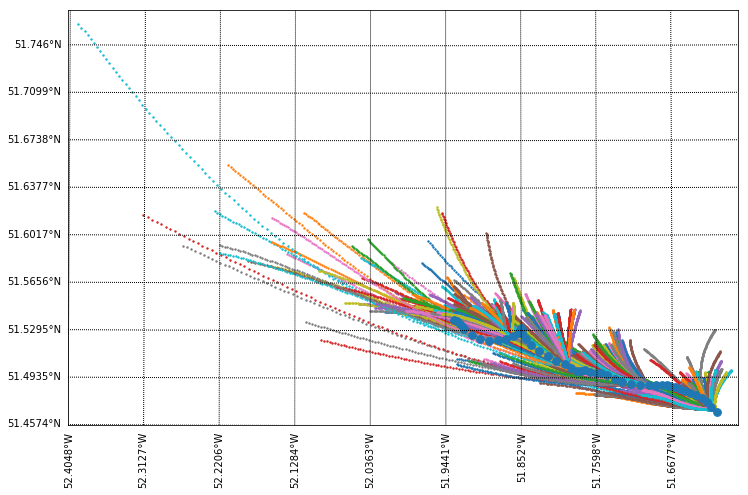

In [8]:
tc = test_case.TestCaseB()

sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

N = 100

plt.rcParams['figure.figsize'] = (12, 12)

num_start_times = 4

err_dict = {'Ca': [], 'Cw': [], 'err': []}

for j in range(num_start_times):
    
    tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    ref_lats_lons = tc.ref_lats, tc.ref_lons
    sim.time_frame = tc.time_frame
    sim.start_location = tc.start_location
    sim.start_velocity = tc.start_velocity
    sim.reload_iceberg()

    for i in range(N):

        Ca = float(np.random.randint(low=35, high=20000, size=1) / 10000)
        Cw = float(np.random.randint(low=35, high=20000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'].append(Ca)
        err_dict['Cw'].append(Cw)
        err_dict['err'].append(err)

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

In [9]:
index = np.argmin(err_dict['err'])
print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][index], err_dict['Ca'][index], err_dict['Cw'][index]))

err: 0.004000778426656898, Ca: 0.9869, Cw: 0.8573


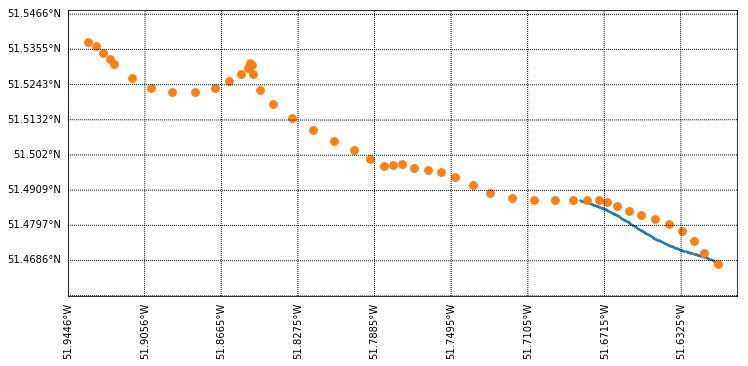

In [10]:
labels = [f'{index}', 'reference']
sizes = [2] + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

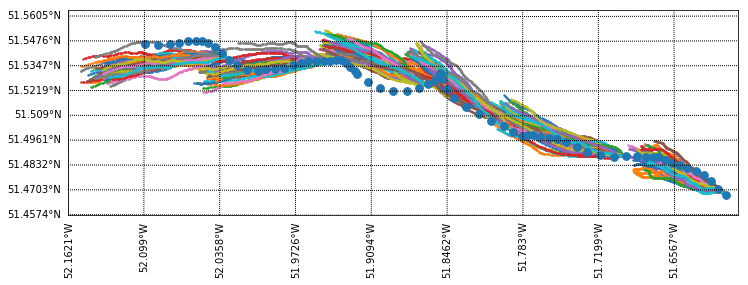

In [2]:
#tc = test_case.TestCase(beacon_id='50519', end_time=np.timedelta64(1, 'D')) #end_time=np.datetime64('2015-04-27T08:00:00'))
tc = test_case.TestCaseB()

sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

N = 40

plt.rcParams['figure.figsize'] = (12, 12)

num_start_times = 6

for j in range(num_start_times):
    
    tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    sim.time_frame = tc.time_frame
    sim.start_location = tc.start_location
    sim.start_velocity = tc.start_velocity
    sim.reload_iceberg()

    for i in range(N):

        #Ca = float(np.random.randint(low=35, high=200, size=1) / 100)
#         Cw = float(np.random.randint(low=35, high=200, size=1) / 100)
        #Cw = Ca / 5
        Ca = 0.9869; Cw = 0.8573
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

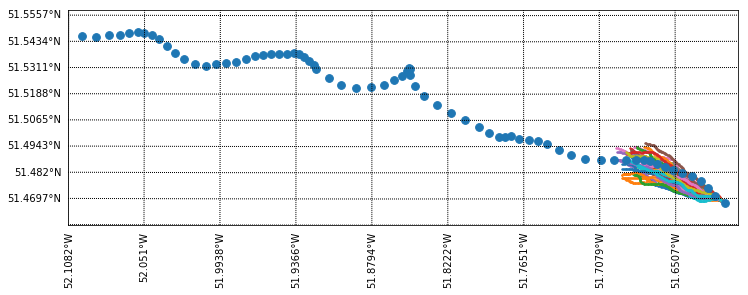

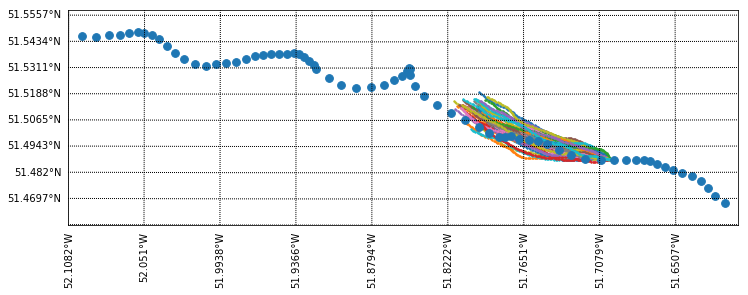

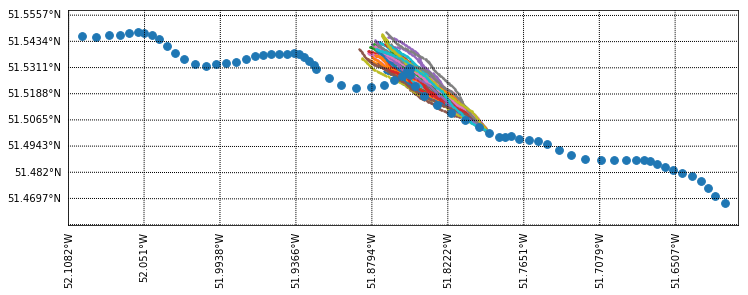

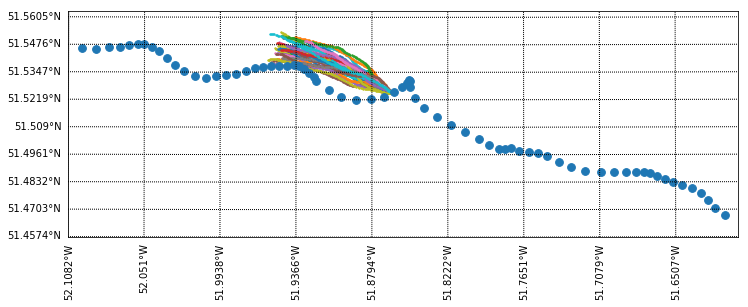

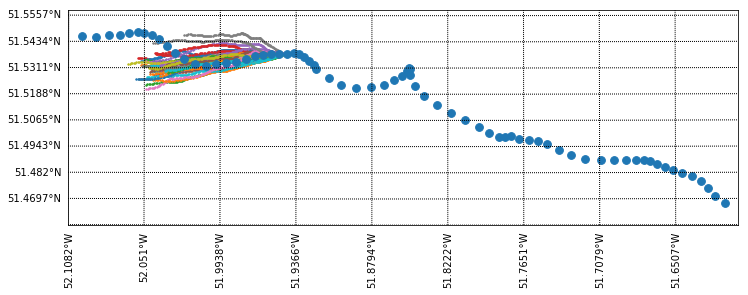

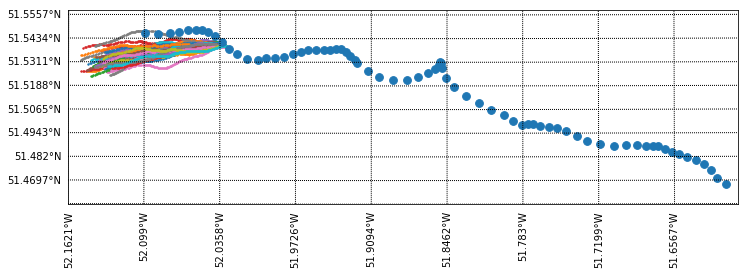

In [3]:
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)

for j in range(num_start_times):
    
    labels = [str(i) for i in range(N * j, N * (j + 1))] + ['reference']
    fig, ax = sim.results.plot(labels, sizes=sizes)

# labels = [str(i) for i in range(N)] + ['reference']
# fig, ax = sim.results.plot(labels, sizes=sizes)

# labels = [str(i) for i in range(N, N * 2)] + ['reference']
# fig, ax = sim.results.plot(labels, sizes=sizes)

# labels = [str(i) for i in range(N * 2, N * 3)] + ['reference']
# fig, ax = sim.results.plot(labels, sizes=sizes)

# labels = [str(i) for i in range(N * 3, N * 4)] + ['reference']
# fig, ax = sim.results.plot(labels, sizes=sizes)

In [22]:
sim.results.data['reference'].sel(time = sim.results.data['reference']['time'].values[12])

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2015-04-25T10:52:09
Data variables:
    latitude   float64 51.49
    longitude  float64 -51.69

In [25]:
sim.results.data['reference'].where(sim.results.data['reference'].time <= sim.results.data['reference']['time'].values[12], drop=True)

<xarray.Dataset>
Dimensions:    (time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2015-04-24T22:53:29 ... 2015-04-25T09:52:26
Data variables:
    latitude   (time) float64 51.47 51.47 51.47 51.48 ... 51.49 51.49 51.49
    longitude  (time) float64 -51.61 -51.62 -51.63 ... -51.67 -51.67 -51.68

In [53]:
for i in range(1, num_start_times + 1):
    if i == 1:
        start_index = 0
        end_index = 11
    else:
        start_index = (i-1) * 12 + 1
        end_index = i * 12 - 1
        
    sim.results.data[f'ref{i}'] = sim.results.data['reference'].where(
        (sim.results.data['reference'].time <= sim.results.data['reference']['time'].values[end_index])
        & (sim.results.data['reference'].time >= sim.results.data['reference']['time'].values[start_index]), drop=True)

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f18c8061a58>)

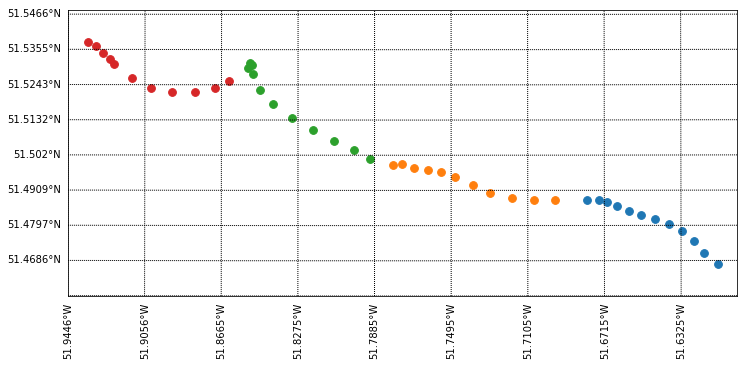

In [54]:
labels = ['ref1', 'ref2', 'ref3', 'ref4']
sizes = [60] * 4
sim.results.plot(labels, sizes=sizes)

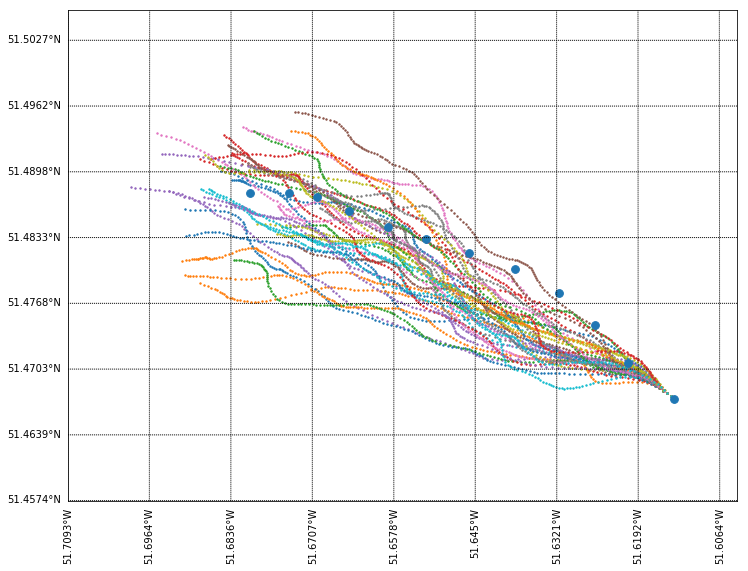

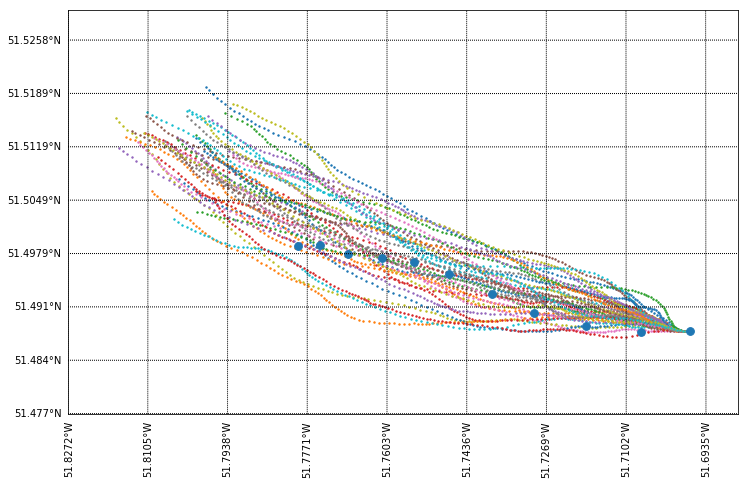

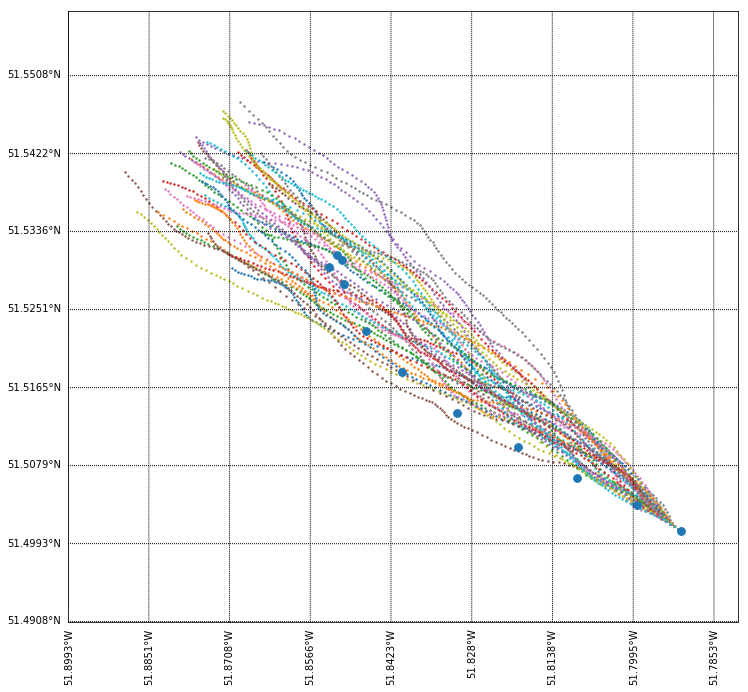

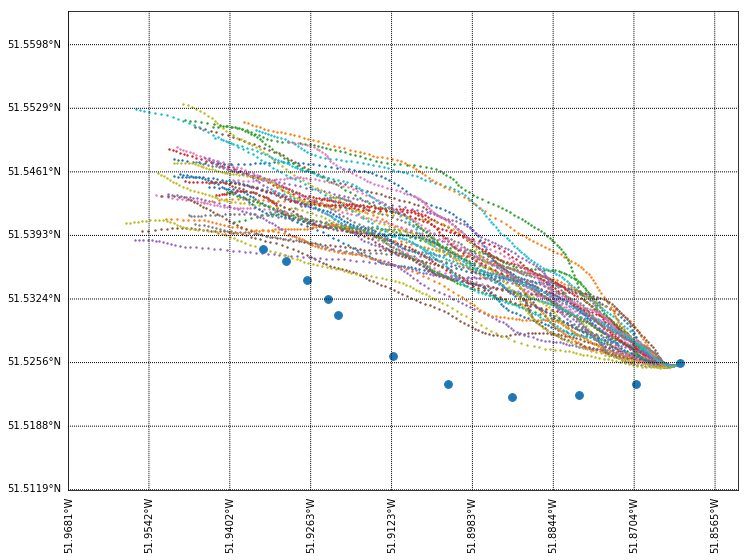

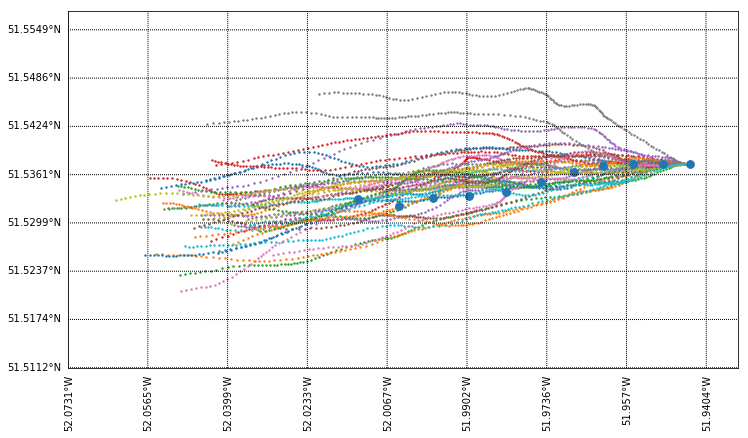

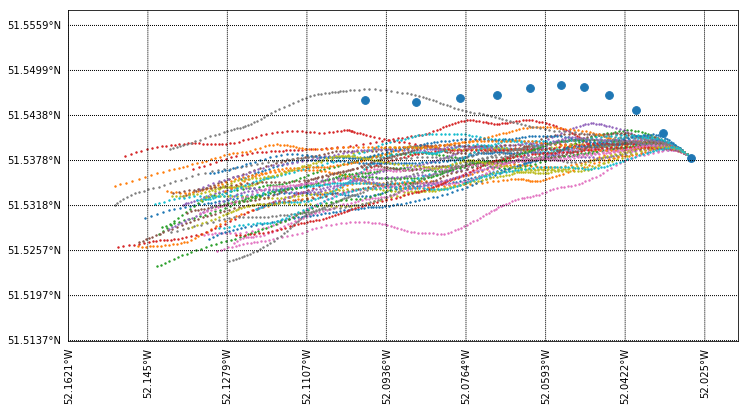

In [55]:
for j in range(num_start_times):
    labels = [str(i) for i in range(N*j, N*(j+1))] + [f'ref{j+1}']
    sizes = [2] * N + [60]
    sim.results.plot(labels, sizes=sizes)

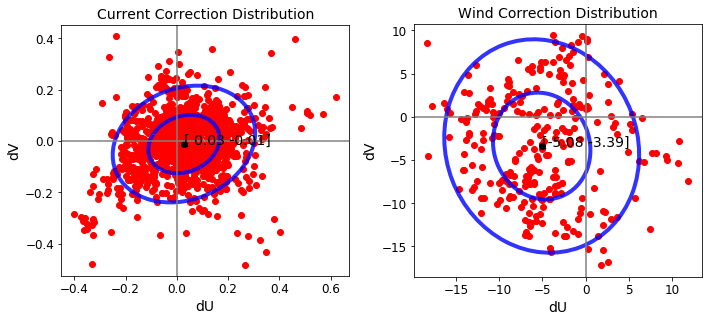

In [21]:
tc.plot_distributions()

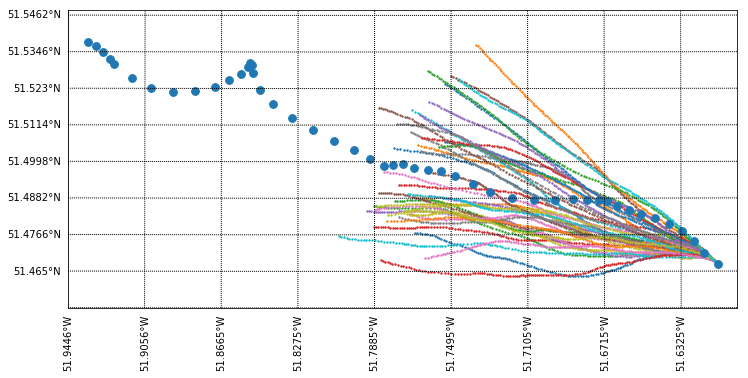

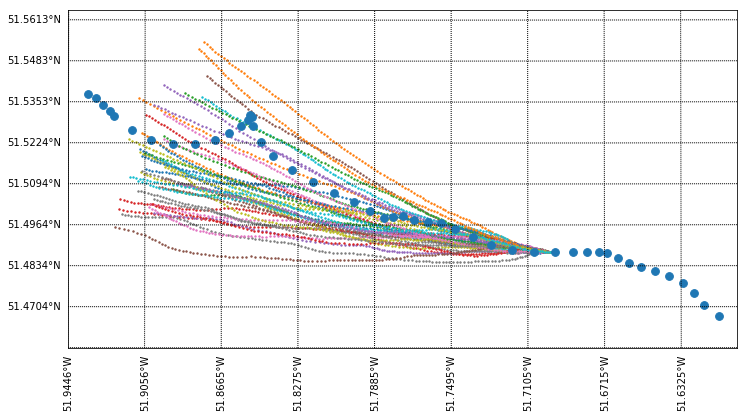

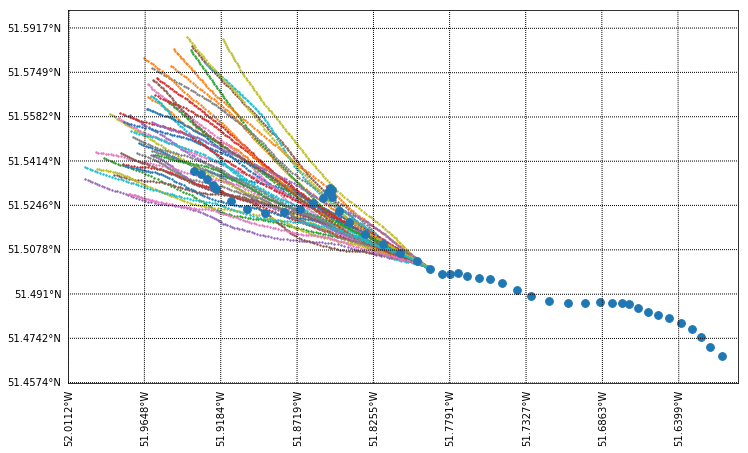

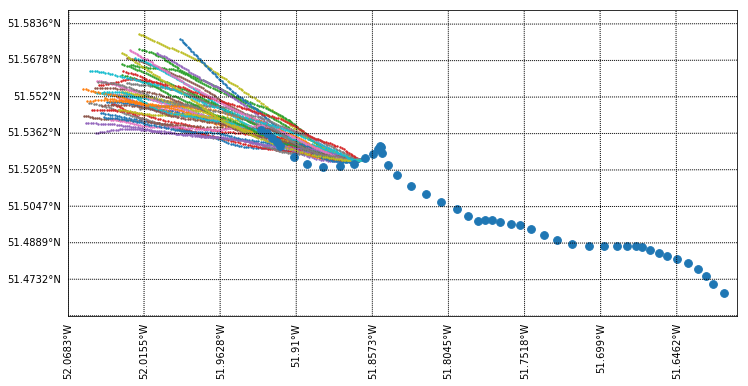

In [13]:
labels = [str(i) for i in range(N)] + ['reference']
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

labels = [str(i) for i in range(N, N * 2)] + ['reference']
fig, ax = sim.results.plot(labels, sizes=sizes)

labels = [str(i) for i in range(N * 2, N * 3)] + ['reference']
fig, ax = sim.results.plot(labels, sizes=sizes)

labels = [str(i) for i in range(N * 3, N * 4)] + ['reference']
fig, ax = sim.results.plot(labels, sizes=sizes)

In [19]:
reload(test_case)

<module 'icedef.test_case' from '/home/evankielley/IceDEF/icedef/test_case.py'>

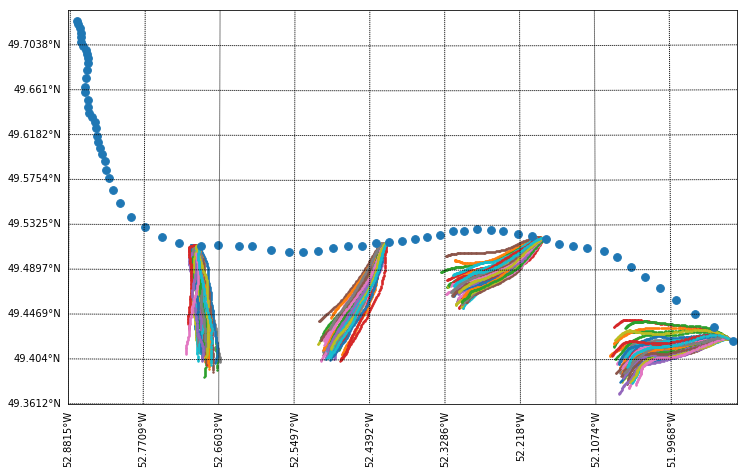

In [20]:
#tc = test_case.TestCase(beacon_id='50519', end_time=np.timedelta64(1, 'D')) #end_time=np.datetime64('2015-04-27T08:00:00'))
tc = test_case.TestCaseC(add_timedelta=np.timedelta64(30, 'h'))

sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

N = 40

plt.rcParams['figure.figsize'] = (12, 12)

num_start_times = 4

for j in range(num_start_times):
    
    tc = test_case.TestCaseC12(add_timedelta=np.timedelta64(30, 'h') + np.timedelta64(12 * j, 'h'))
    sim.time_frame = tc.time_frame
    sim.start_location = tc.start_location
    sim.start_velocity = tc.start_velocity
    sim.reload_iceberg()

    for i in range(N):

        Ca = float(np.random.randint(low=35, high=200, size=1) / 100)
#         Cw = float(np.random.randint(low=35, high=200, size=1) / 100)
        Cw = Ca / 2
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

In [2]:
#tc = test_case.TestCase(beacon_id='50519', end_time=np.timedelta64(1, 'D')) #end_time=np.datetime64('2015-04-27T08:00:00'))
tc = test_case.TestCaseC()

sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 10

plt.rcParams['figure.figsize'] = (12, 12)

num_start_times = 4

for j in range(num_start_times):
    
    tc = test_case.TestCaseC6(add_timedelta=np.timedelta64(6 * j, 'h'))
    sim.time_frame = tc.time_frame
    sim.start_location = tc.start_location
    sim.start_velocity = tc.start_velocity
    sim.reload_iceberg()

    for i in range(N):

        Ca = float(np.random.randint(low=1, high=20, size=1) / 1000)
        Cw = float(np.random.randint(low=1, high=20, size=1) / 100)
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

In [3]:
tcs = []
sims = []
for i in range(10):
    i *= 6
    #tc = test_case.TestCaseB6(add_timedelta=np.timedelta64(i, 'h'))
    tc = test_case.TestCaseC6(add_timedelta=np.timedelta64(i, 'h'))
    #tc = test_case.TestCaseC12(add_timedelta=np.timedelta64(i, 'h'))
    sim_args = tc.time_frame, tc.start_location, tc.start_velocity
    sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
    reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
    sim.results.add_from_dict(reference_data_dict, label='reference')
    sim.testcase = tc
    tcs.append(tc)
    sims.append(sim)

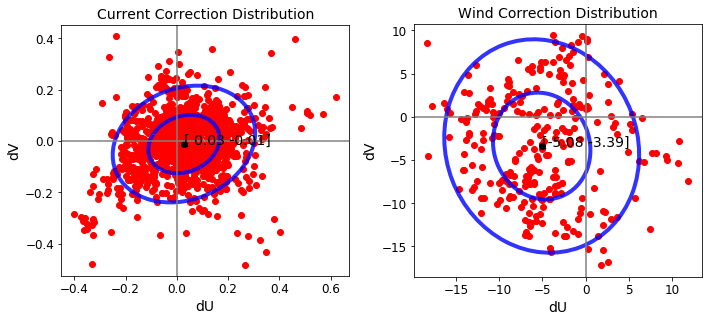

In [5]:
tc.plot_distributions()

In [9]:
tc.avos_ds.time.values[-1]

numpy.datetime64('2015-04-27T08:00:00.000000000')

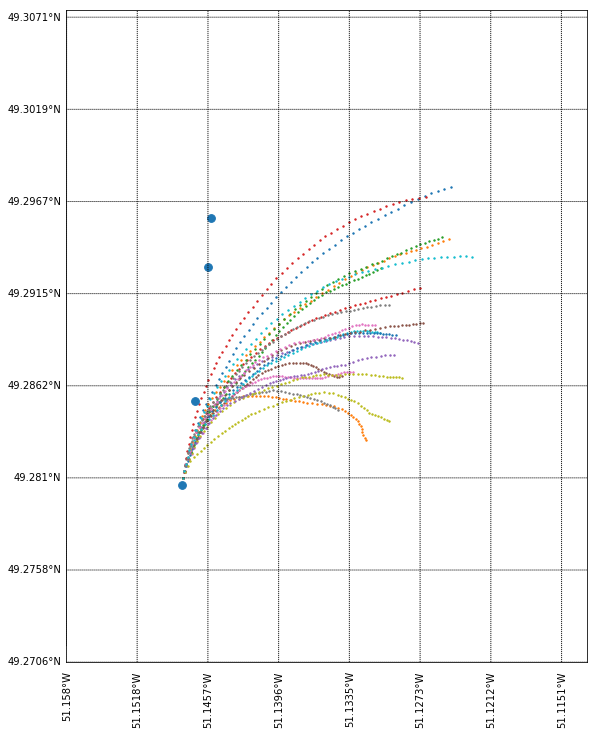

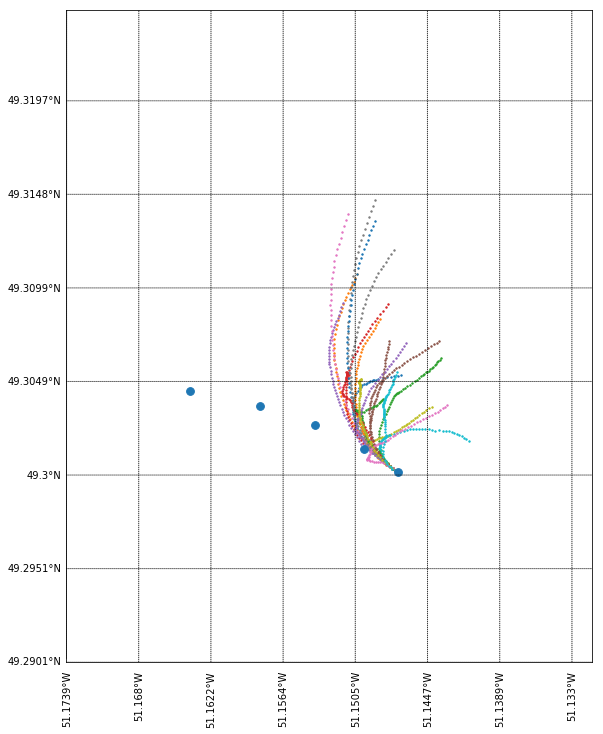

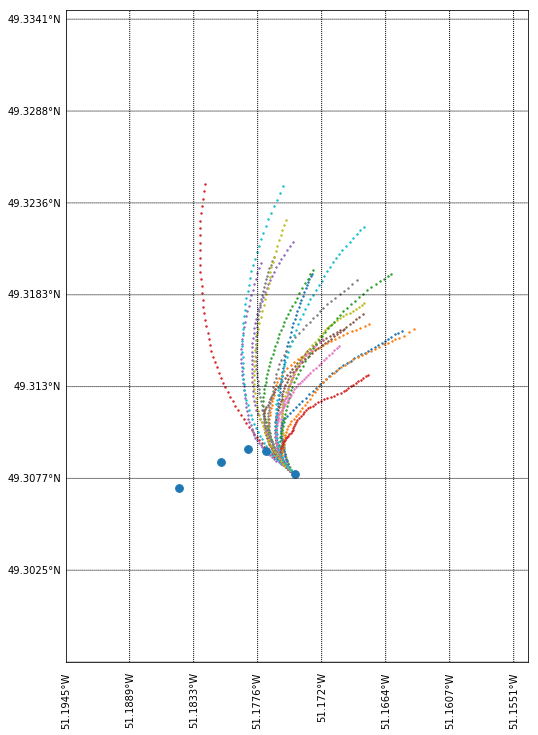

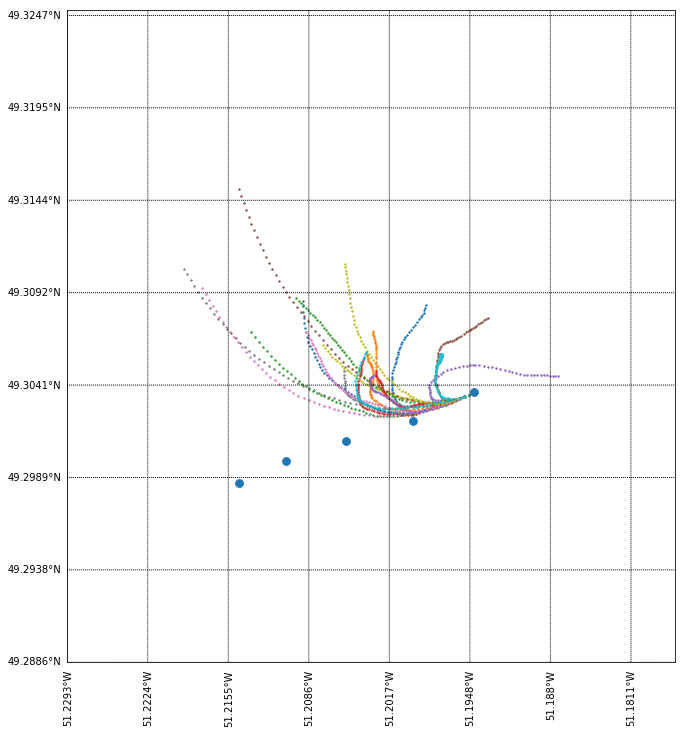

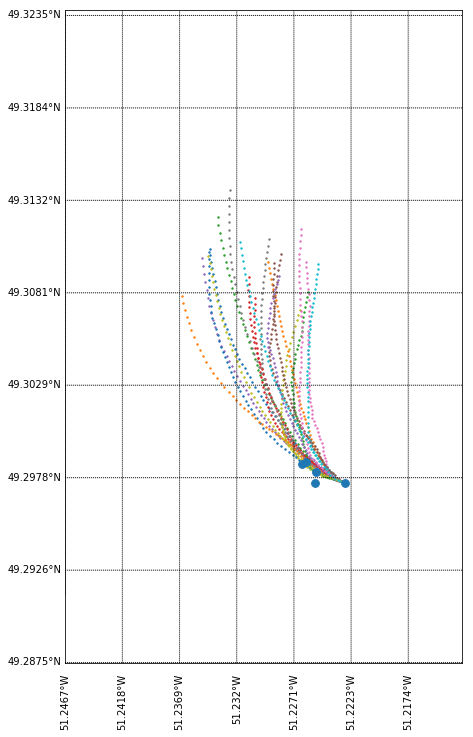

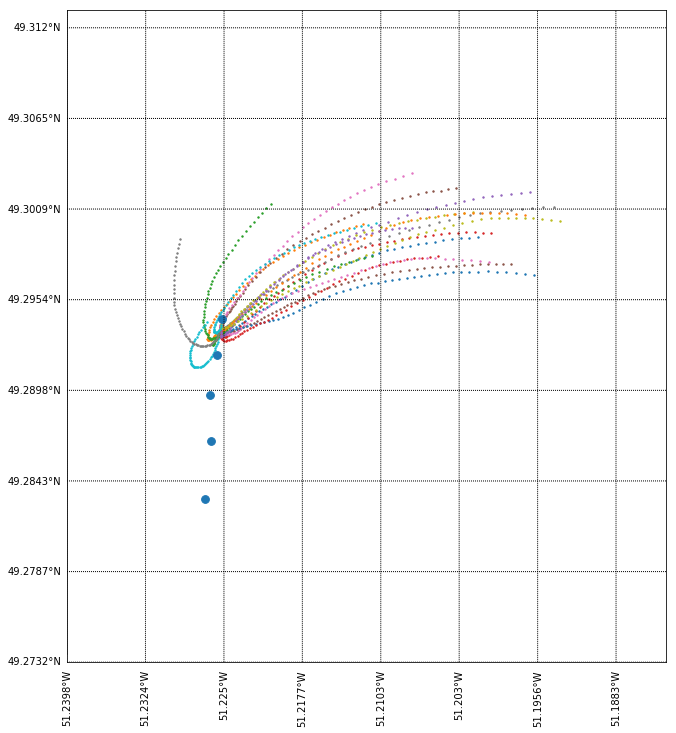

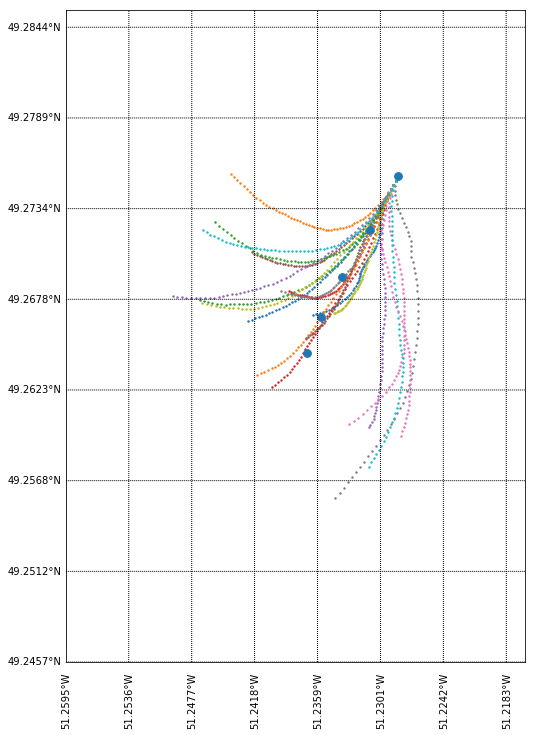

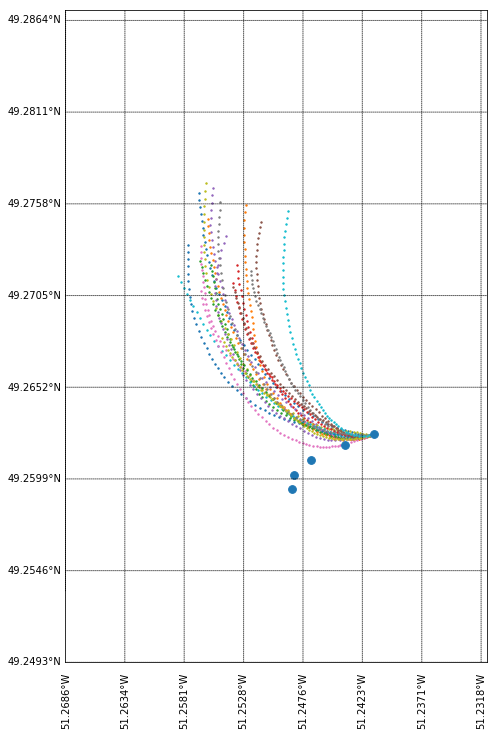

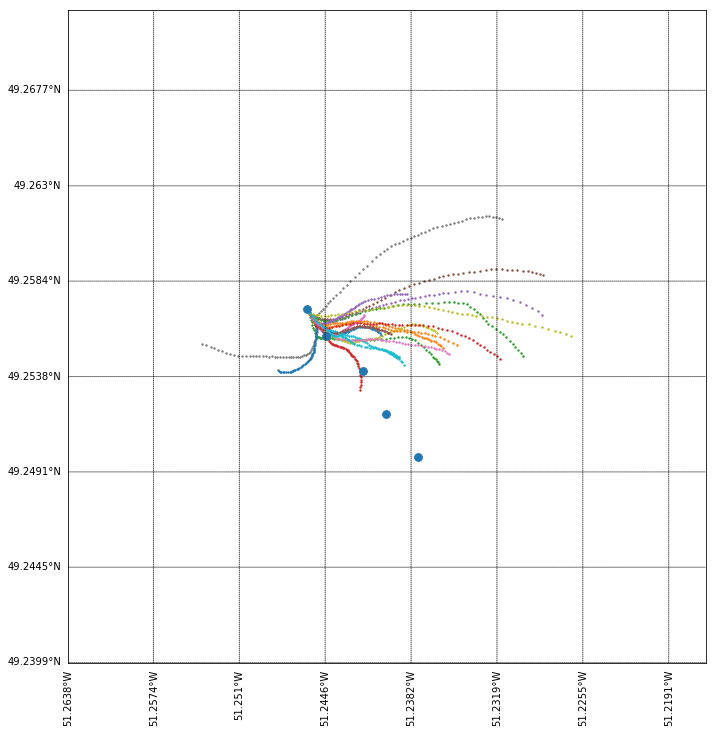

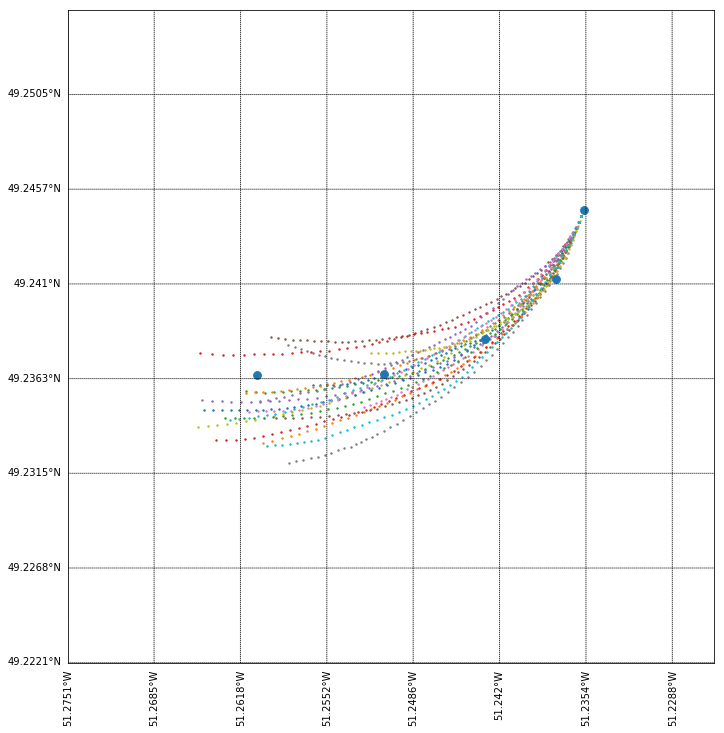

In [9]:
Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 20

plt.rcParams['figure.figsize'] = (12, 12)

for sim in sims:
    
    for i in range(N):

        Ca = float(np.random.randint(low=1, high=20, size=1) / 1000)
        Cw = float(np.random.randint(low=1, high=20, size=1) / 100)
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i}', **run_sim_kwargs)

    labels = [str(i) for i in range(N)] + ['reference']
    sizes = [2] * N + [60]
    markers = ['.'] * (N + 1)
    fig, ax = sim.results.plot(labels, sizes=sizes)

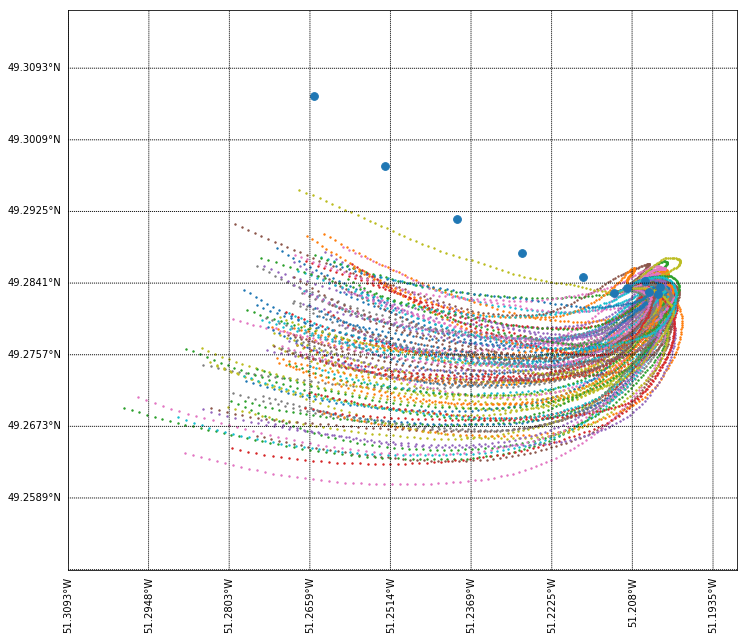

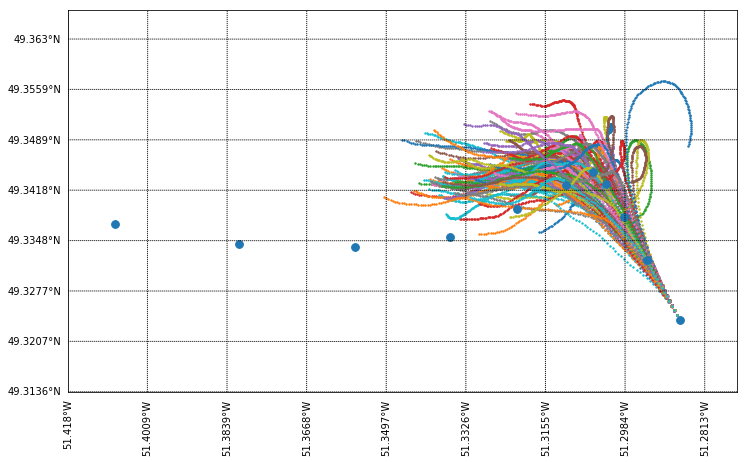

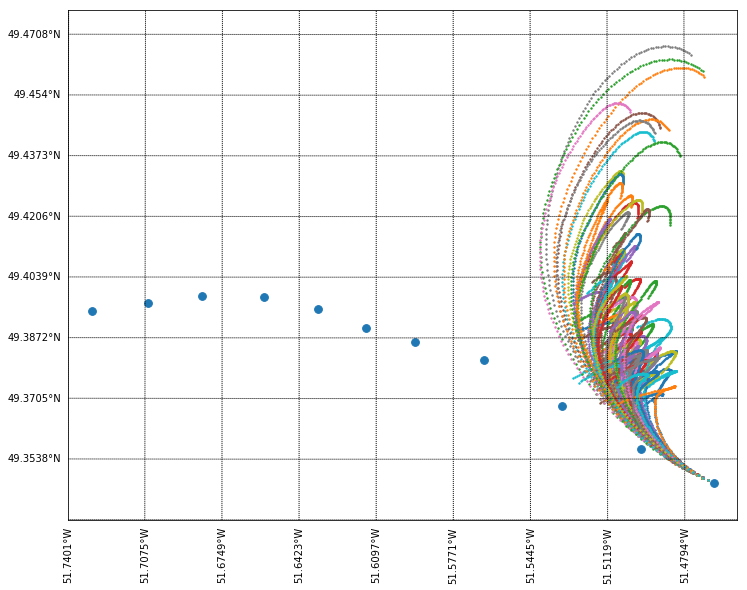

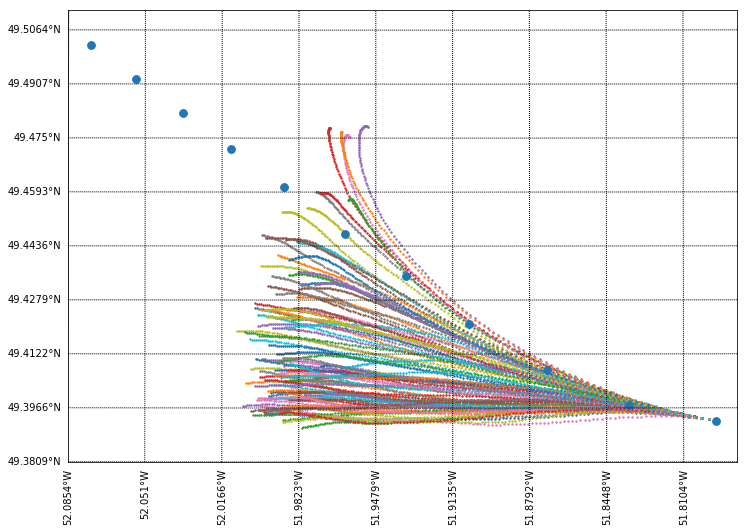

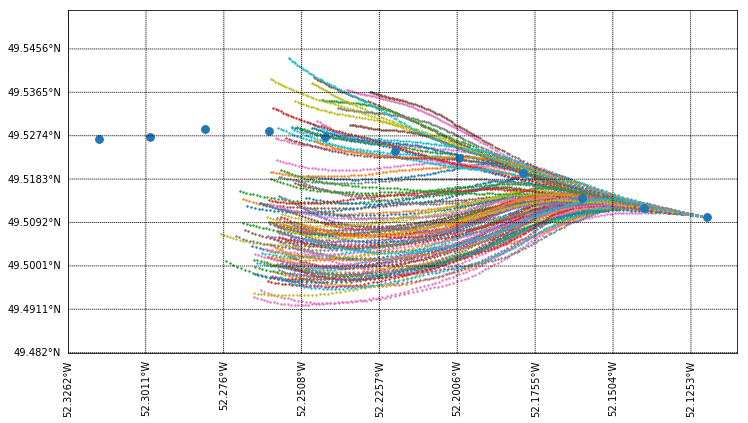

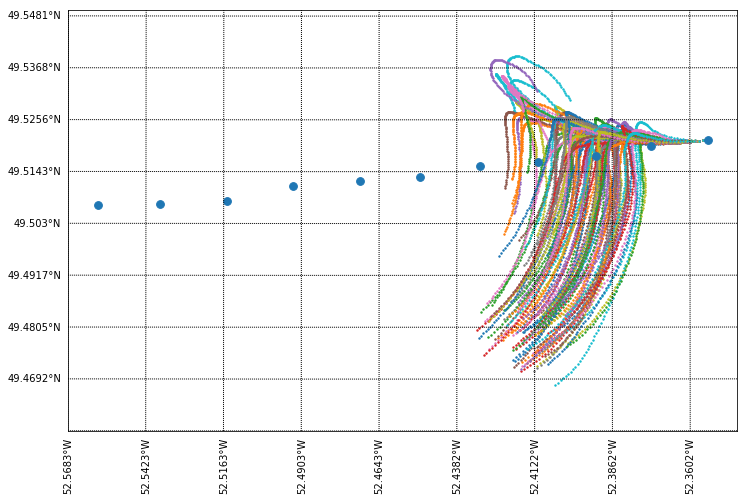

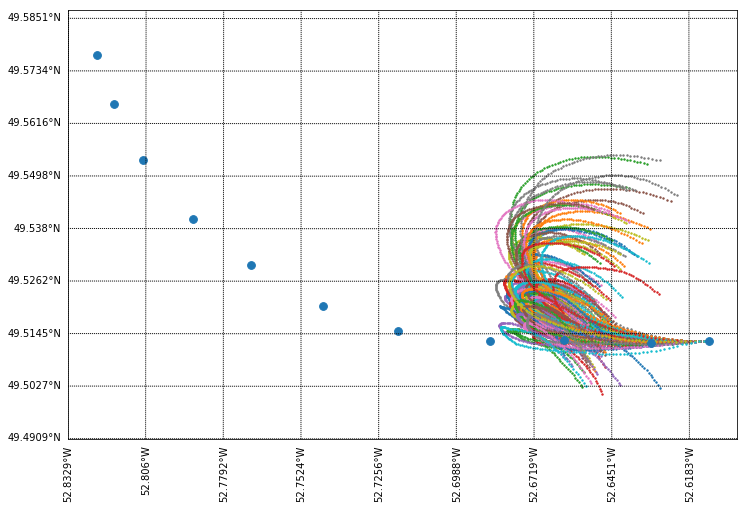

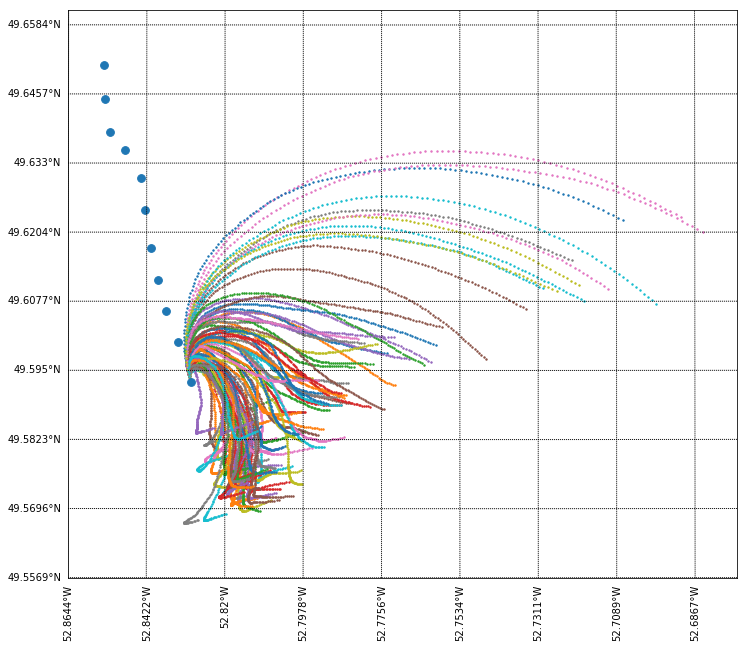

In [4]:
Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 100

plt.rcParams['figure.figsize'] = (12, 12)

for sim in sims:
    
    for i in range(N):

        Ca = np.random.randint(low=1, high=20, size=1) / 1000
        Cw = np.random.randint(low=1, high=20, size=1) / 100
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i}', **run_sim_kwargs)

    labels = [str(i) for i in range(N)] + ['reference']
    sizes = [2] * N + [60]
    markers = ['.'] * (N + 1)
    fig, ax = sim.results.plot(labels, sizes=sizes)

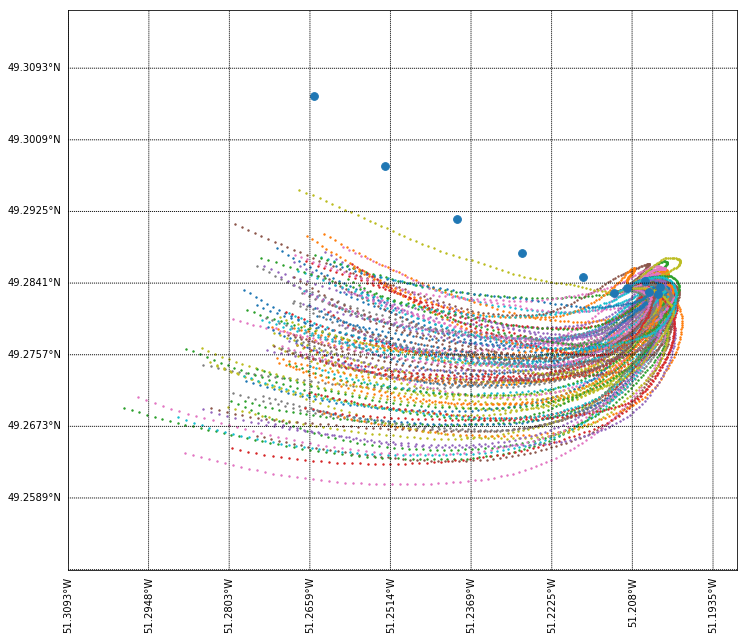

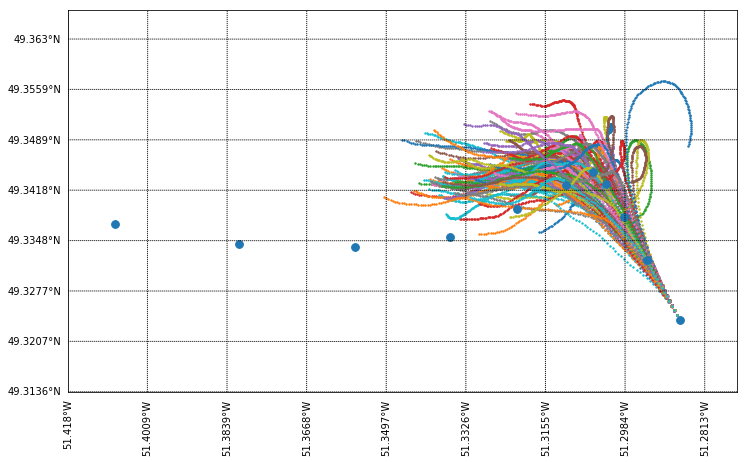

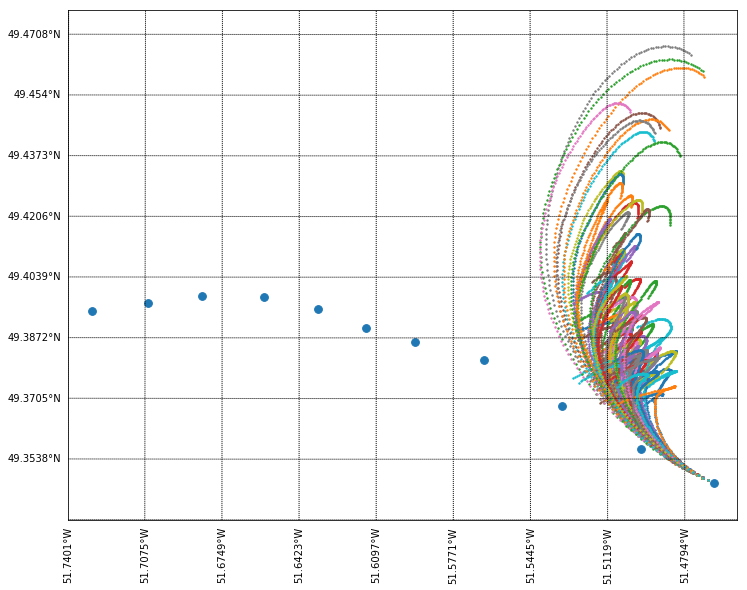

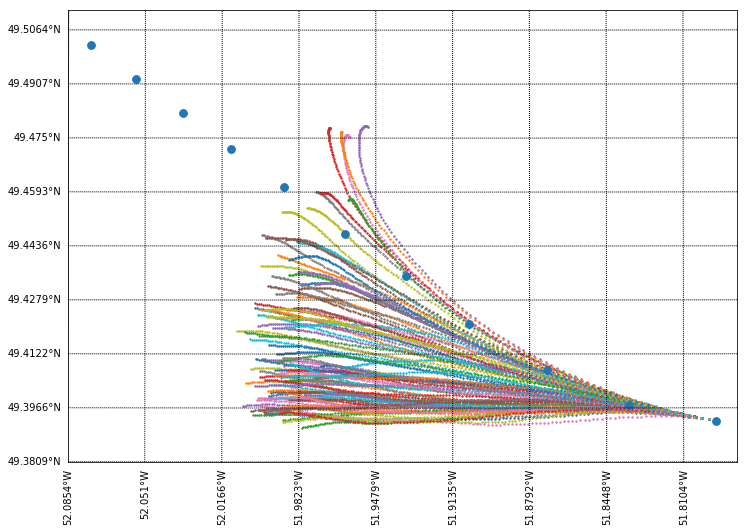

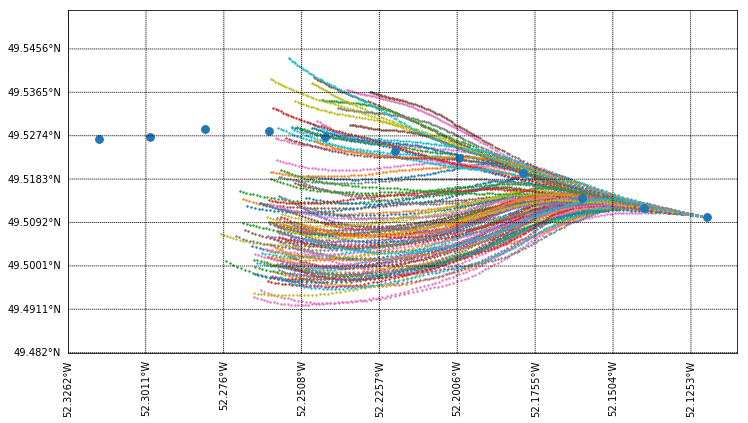

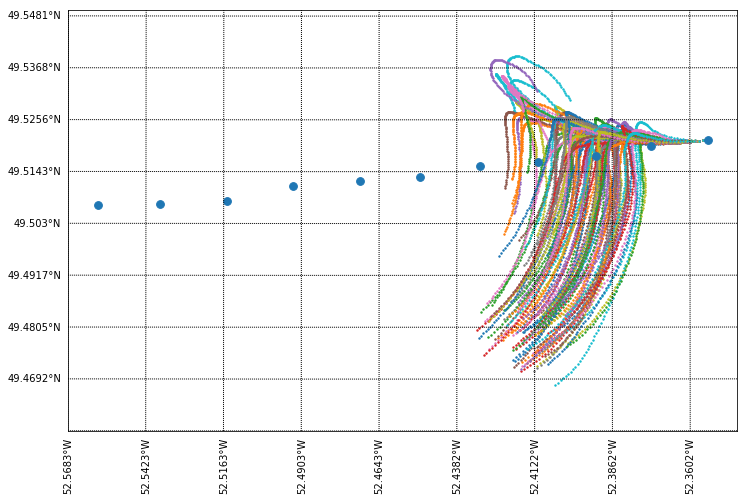

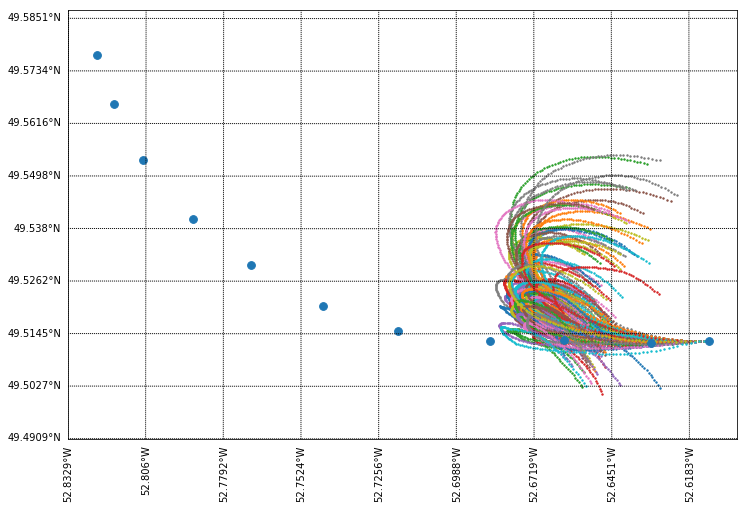

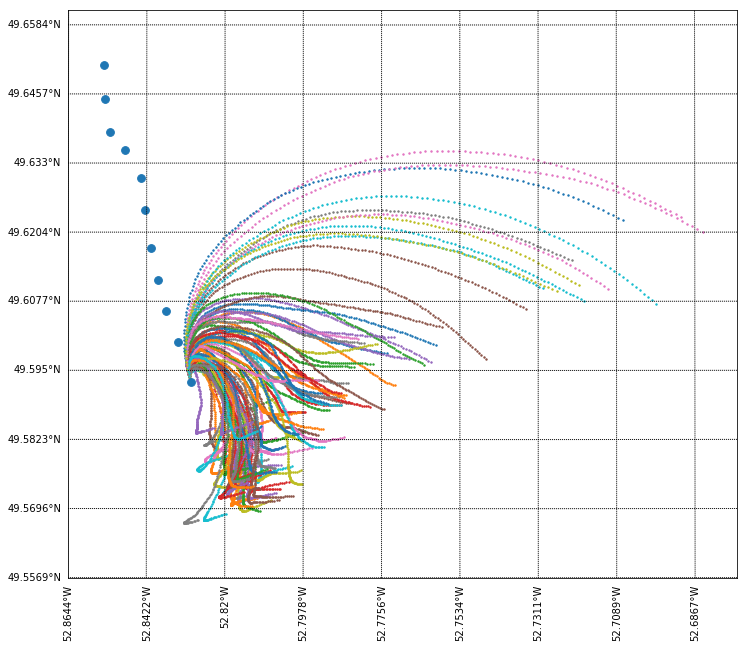

In [4]:
Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 100

plt.rcParams['figure.figsize'] = (12, 12)

for sim in sims:
    
    for i in range(N):

        Ca = np.random.randint(low=1, high=20, size=1) / 1000
        Cw = np.random.randint(low=1, high=20, size=1) / 100
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i}', **run_sim_kwargs)

    labels = [str(i) for i in range(N)] + ['reference']
    sizes = [2] * N + [60]
    markers = ['.'] * (N + 1)
    fig, ax = sim.results.plot(labels, sizes=sizes)

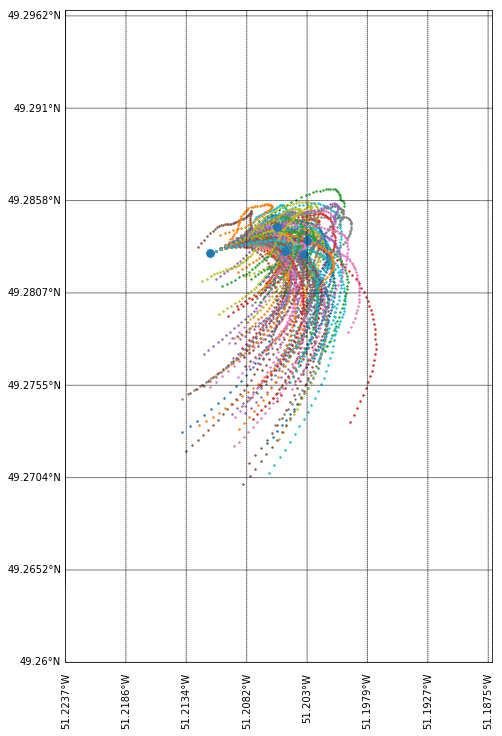

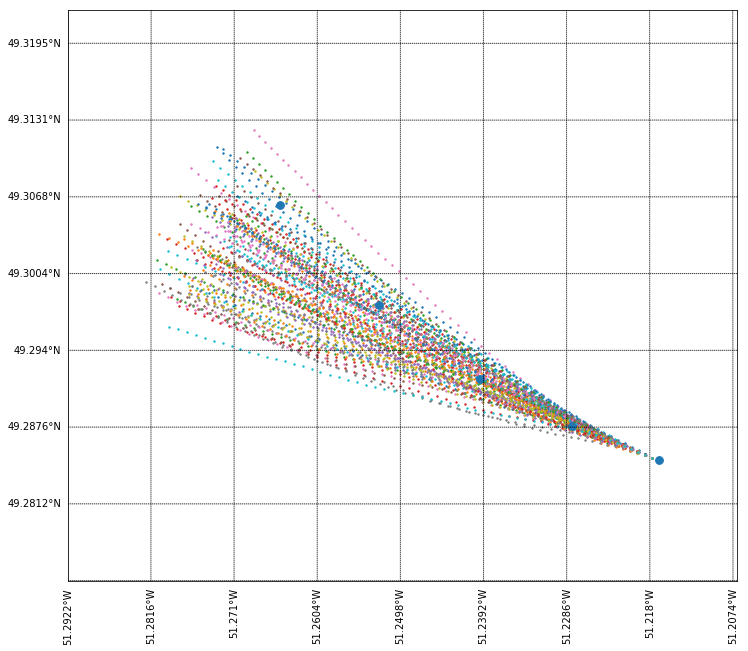

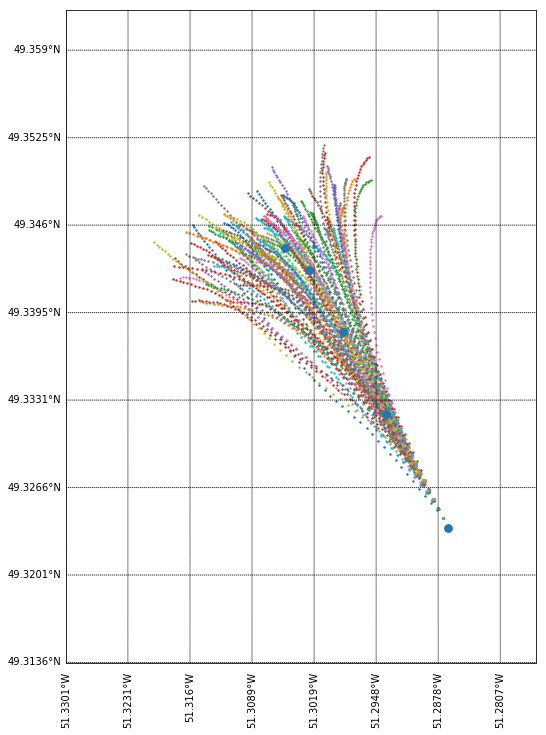

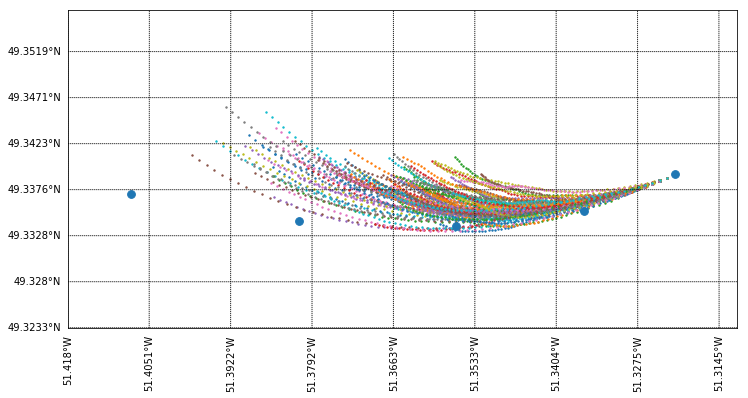

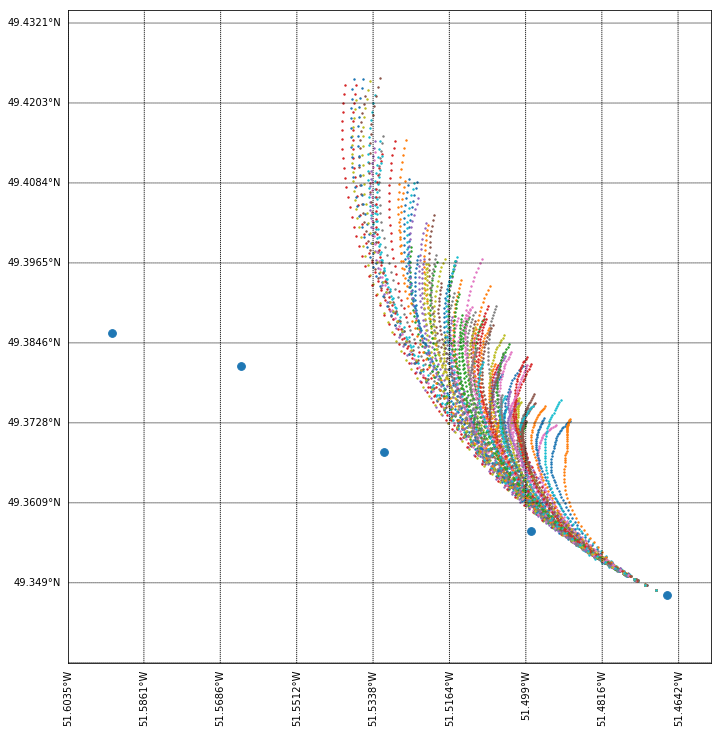

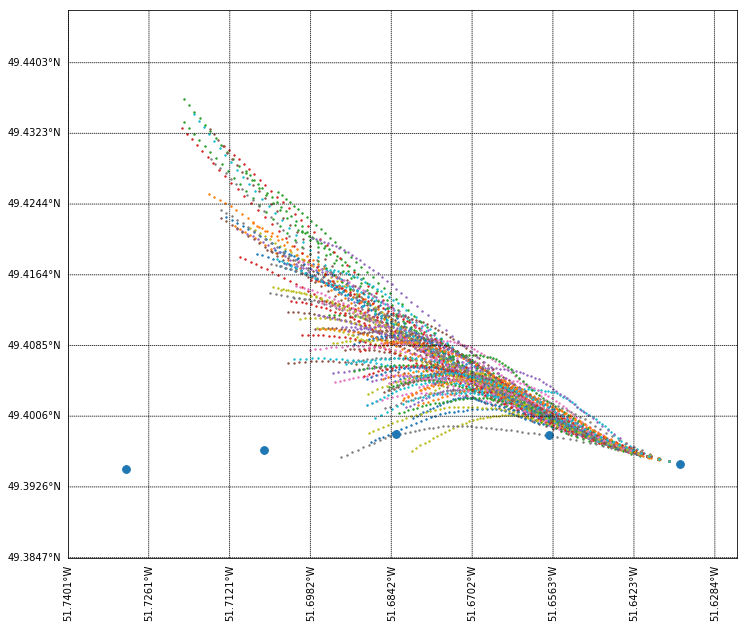

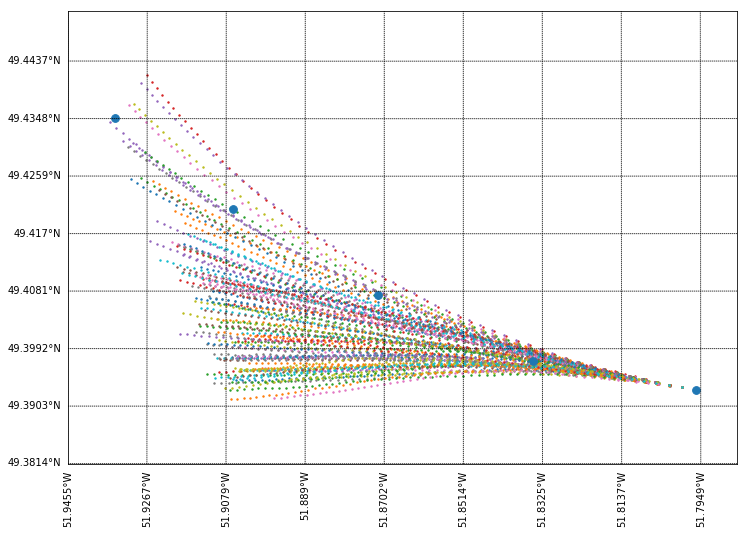

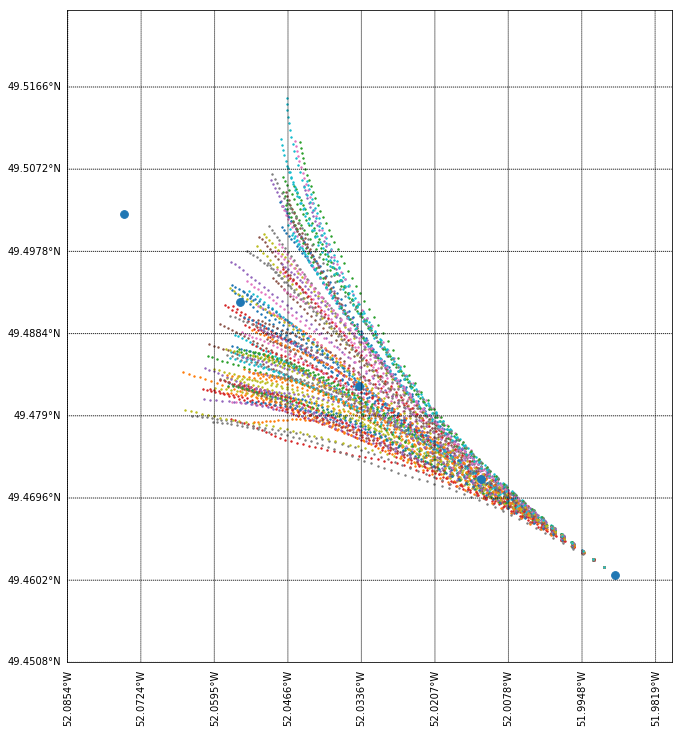

In [8]:
Ca, Cw = 0.1, 0.15
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 100

plt.rcParams['figure.figsize'] = (12, 12)

for sim in sims:
    
    for i in range(N):

        Ca = np.random.randint(low=1, high=20, size=1) / 1000
        Cw = np.random.randint(low=1, high=20, size=1) / 100
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i}', **run_sim_kwargs)

    labels = [str(i) for i in range(N)] + ['reference']
    sizes = [2] * N + [60]
    markers = ['.'] * (N + 1)
    fig, ax = sim.results.plot(labels, sizes=sizes)

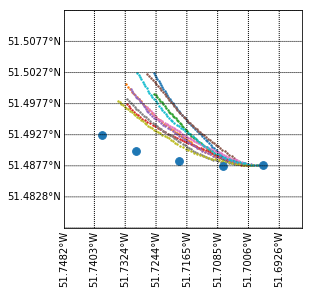

In [5]:
labels = [str(i) for i in range(N)] + ['reference']
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

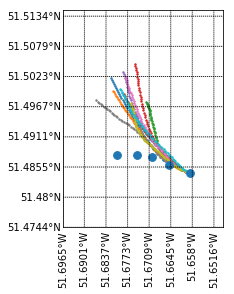

In [11]:
labels = [str(i) for i in range(N)] + ['reference']
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

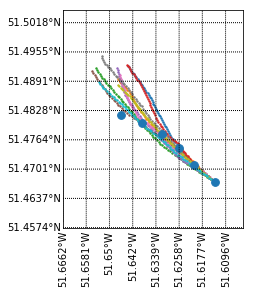

In [5]:
labels = [str(i) for i in range(N)] + ['reference']
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

In [14]:
(tc.time_frame[1] - tc.time_frame[0]) / np.timedelta64(300, 's')

71.92

In [18]:
pd.read_csv('debug.log').iloc[71], pd.read_csv('debug.log').iloc[0] 

(-653414.3775214253        -160193.520148
 -463275.6611567889        -212506.634798
 102998.35618933222         178838.123220
 -349115.4295781457         -59501.304663
 68610.38581703525           54398.292174
 88377.32876034683           94771.421260
 155208.51515350686          -5755.359686
 -3608.7190650390835         85782.814903
 -23.316318004419173           -10.008825
 -16.321018877395982           -12.988600
 -0.03310923903806375            0.110027
 -0.25797871370621084            0.000048
 -1.0475732859489337e-06        -0.000001
 3.1173316275637473e-06          0.000003
 Name: 71, dtype: float64, -653414.3775214253        -103910.890337
 -463275.6611567889         -81649.121600
 102998.35618933222         164391.581481
 -349115.4295781457           8577.565819
 68610.38581703525           52008.156205
 88377.32876034683           95829.325537
 155208.51515350686         -66124.295581
 -3608.7190650390835         81994.224677
 -23.316318004419173            -9.226826
 -16.321

In [ ]:
tc.time_frame

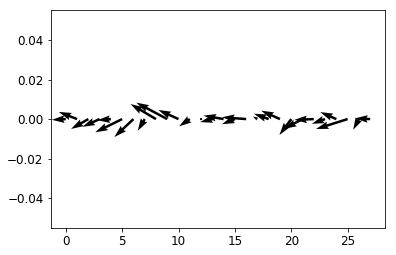

In [6]:
plt.quiver(sim.results.data['0']['Vwx'].values[::10], sim.results.data['0']['Vwy'].values[::10])

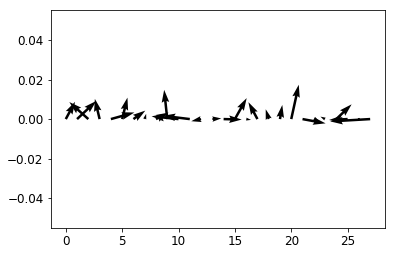

In [7]:
plt.quiver(sim.results.data['0']['Vcx'].values[::10], sim.results.data['0']['Vcy'].values[::10])

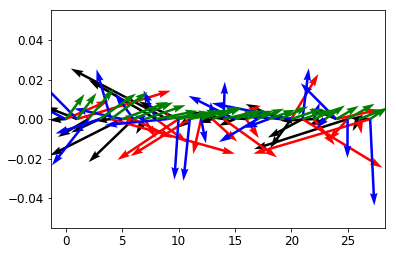

In [8]:
plt.quiver(sim.results.data['0']['Fax'].values[::10], sim.results.data['0']['Fay'].values[::10], scale=1e6)
plt.quiver(sim.results.data['0']['Fwx'].values[::10], sim.results.data['0']['Fwy'].values[::10], scale=1e6, color='r')
plt.quiver(sim.results.data['0']['Fwpx'].values[::10], sim.results.data['0']['Fwpy'].values[::10], scale=1e6, color='b')
plt.quiver(sim.results.data['0']['Fcx'].values[::10], sim.results.data['0']['Fcy'].values[::10], scale=1e6, color='g')

# END SANDBOX

In [2]:
tcs = {}
sims = {}

for i in range(1):
    
    tc = test_case.TestCaseB(add_timedelta=np.timedelta64(i, 'D'))
    sim_args = tc.time_frame, tc.start_location, tc.start_velocity
    sim = simulator.Simulator(*sim_args)
    reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
    sim.results.add_from_dict(reference_data_dict, label='reference')
    tcs[str(i)] = tc
    sims[str(i)] = sim

In [31]:
def dummy(sim_stuff):
    sim_, run_sim_kwargs = sim_stuff
    result = sim_.run_simulation(**run_sim_kwargs)
    return result

In [39]:
%%time
Ca, Cw = 0.1, 0.2
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 16
all_results = {}
for j in range(len(tcs)):
    l = []
    results = {}
    for i in range(N):      
        l.append((sim, run_sim_kwargs))
    pool = mp.Pool(4)
    results = pool.map(dummy, l)
    pool.close()
    pool.join()
    all_results[str(j)] = results

CPU times: user 2.22 s, sys: 2.92 s, total: 5.14 s
Wall time: 7.1 s


In [84]:
Ca, Cw = 0.01, 0.12
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}

N = 40

for i in range(N):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    
calc_mean_err(sim, None)

0.015249585824237718

In [91]:
def fun(CaCw):
    print('Starting')
    Ca, Cw = CaCw
    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}
    sim = simulator.Simulator(*sim_args)
    reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
    sim.results.add_from_dict(reference_data_dict, label='reference')
    
    N = 40
    
    for i in range(N):
        sim.run_simulation(label=f'{i}', **run_sim_kwargs)
        
    return calc_mean_err(sim, None)

In [92]:
optimization_result = scipy.optimize.minimize(fun, x0=[0.01, 0.12], bounds=[[0.01, 0.2], [0.01, 0.2]])
optimization_result

Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting
Starting


      fun: 0.01806999486051965
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -23640.52005318, -242287.01026426])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 2
   status: 0
  success: True
        x: array([0.01      , 0.12000118])

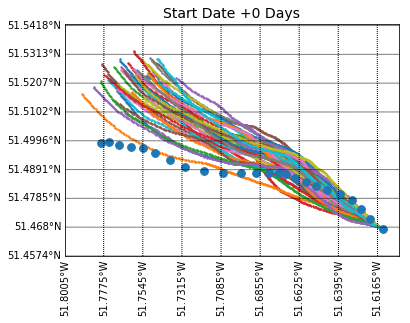

In [85]:
labels = [str(i) for i in range(N)] + ['reference']
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)
plt.rcParams['figure.figsize'] = (6, 6)

for i in range(len(tcs)):
    sim = sims[str(i)]
    title = f'Start Date +{i} Days'
    fig, ax = sim.results.plot(labels, sizes=sizes, title=title)

In [41]:
for i, result in enumerate(results):
    sim = sims[str(j)]
    sim.results.data[f'{i}'] = result

labels = [str(i) for i in range(N)] + ['reference']
sizes = [2] * N + [60]
markers = ['.'] * (N + 1)



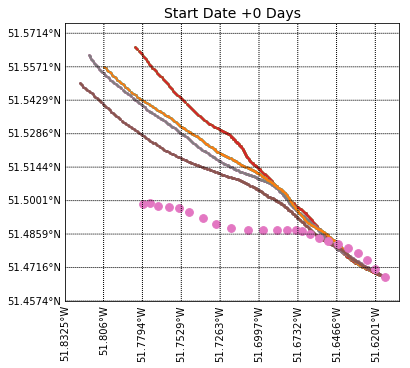

In [42]:
plt.rcParams['figure.figsize'] = (6, 6)

for i in range(len(tcs)):
    sim = sims[str(i)]
    title = f'Start Date +{i} Days'
    fig, ax = sim.results.plot(labels, sizes=sizes, title=title)

In [48]:
def optimize_wrapper(values, keys, sim):
    
    sim_kwargs = dict(zip(keys, values))
    sim_kwargs.update({'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1})
    results = sim.run_simulation(**sim_kwargs)
    N = 5
    all_results = {}
    tcs = []
    for j in range(len(tcs)):
        l = []
        results = {}
        for i in range(N):      
            l.append((i, j, run_sim_kwargs, sims[str(j)]))
        pool = mp.Pool(4)
        results = pool.map(dummy, l)
        pool.close()
        pool.join()
    
    mean_err = calc_mean_err(sim, results)
    return mean_err

In [8]:
def calc_mean_err(sim, data, N):
    
    ts = sim.results.data['reference'].time.values
    lats = sim.results.data['reference'].latitude.values
    lons = sim.results.data['reference'].longitude.values
    labels = [str(i) for i in range(N)]
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            data = sim.results.data[label]
            sim_lats[i, j] = float(data['latitude'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(data['longitude'].interp(time=t, assume_sorted=True).values)

    mean_lats = np.mean(sim_lats, axis=1)
    mean_lons = np.mean(sim_lons, axis=1)

    err = np.sqrt((lons - mean_lons)**2 + (lats - mean_lats)**2)
    mean_err = np.mean(err)
    
    return mean_err

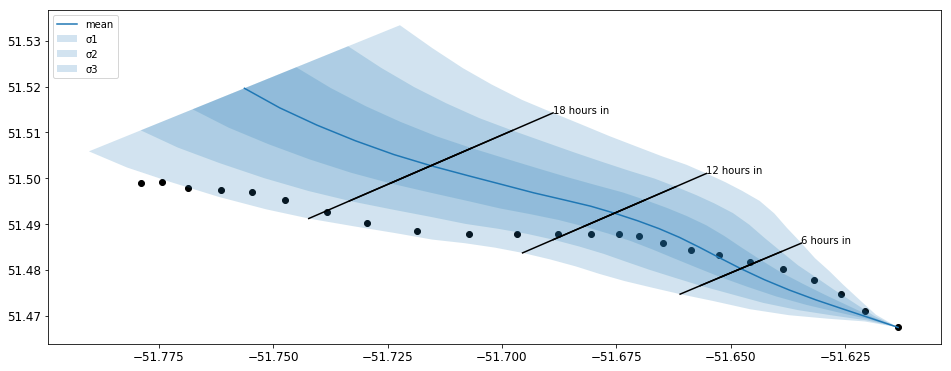

In [86]:
#sim = sims['0']
ts = sim.results.data['reference'].time.values
lats = sim.results.data['reference'].latitude.values
lons = sim.results.data['reference'].longitude.values
labels = [str(i) for i in range(N)]
sim_lats = np.empty((len(ts), len(labels)))
sim_lons = np.empty((len(ts), len(labels)))

for i in range(len(ts)):
    t = ts[i]
    for j, label in enumerate(labels):
        data = sim.results.data[label]
        sim_lats[i, j] = float(data['latitude'].interp(time=t, assume_sorted=True).values)
        sim_lons[i, j] = float(data['longitude'].interp(time=t, assume_sorted=True).values)

fig = plt.figure(figsize=(16, 12))
        
with warnings.catch_warnings():

    warnings.simplefilter("ignore")

    mean_lats = np.mean(sim_lats, axis=1)
    mean_lons = np.mean(sim_lons, axis=1) 
    
    std1_lats = np.std(sim_lats, axis=1)
    std1_lons = np.std(sim_lons, axis=1)
    
    min1_lats = mean_lats - std1_lats
    min1_lons = mean_lons - std1_lons
    max1_lats = mean_lats + std1_lats
    max1_lons = mean_lons + std1_lons
    
    min2_lats = mean_lats - 2 * std1_lats
    min2_lons = mean_lons - 2 * std1_lons
    max2_lats = mean_lats + 2 * std1_lats
    max2_lons = mean_lons + 2 * std1_lons
    
    min3_lats = mean_lats - 3 * std1_lats
    min3_lons = mean_lons - 3 * std1_lons
    max3_lats = mean_lats + 3 * std1_lats
    max3_lons = mean_lons + 3 * std1_lons

    plt.plot(mean_lons, mean_lats, label='mean')
    
    polygon1_xys = np.column_stack((np.vstack((min1_lons, max1_lons[::-1])).ravel(), 
                                    np.vstack((min1_lats, max1_lats[::-1])).ravel()))
    polygon2_xys = np.column_stack((np.vstack((min2_lons, max2_lons[::-1])).ravel(), 
                                    np.vstack((min2_lats, max2_lats[::-1])).ravel()))
    polygon3_xys = np.column_stack((np.vstack((min3_lons, max3_lons[::-1])).ravel(), 
                                    np.vstack((min3_lats, max3_lats[::-1])).ravel()))

    polygon1 = Polygon(polygon1_xys, fill=True, alpha=0.2, label='σ1')
    polygon2 = Polygon(polygon2_xys, fill=True, alpha=0.2, label='σ2')
    polygon3 = Polygon(polygon3_xys, fill=True, alpha=0.2, label='σ3')

    ax = plt.gca()
    ax.add_patch(polygon1)
    ax.add_patch(polygon2)
    ax.add_patch(polygon3)

    ax.scatter(lons, lats, color='k')
    
    
    # ADDING TIME LINES
    for dt in np.arange(6, 24, 6):
        for min_lons, max_lons, min_lats, max_lats in zip([min1_lons, min2_lons, min3_lons], 
                                                                 [max1_lons, max2_lons, max3_lons],
                                                                 [min1_lats, min2_lats, min3_lats], 
                                                                 [max1_lats, max2_lats, max3_lats]):

            xr_min_lats = xr.DataArray(data=min_lats, coords=[ts], dims=['time'])
            xr_min_lons = xr.DataArray(data=min_lons, coords=[ts], dims=['time'])
            xr_max_lats = xr.DataArray(data=max_lats, coords=[ts], dims=['time'])
            xr_max_lons = xr.DataArray(data=max_lons, coords=[ts], dims=['time'])
            t = ts[0] + np.timedelta64(int(dt), 'h')
            xr_min_lat = float(xr_min_lats.interp(time=t, assume_sorted=True).values)
            xr_min_lon = float(xr_min_lons.interp(time=t, assume_sorted=True).values)
            xr_max_lat = float(xr_max_lats.interp(time=t, assume_sorted=True).values)
            xr_max_lon = float(xr_max_lons.interp(time=t, assume_sorted=True).values)
            plt.plot([xr_min_lon, xr_max_lon], [xr_min_lat, xr_max_lat], color='k', zorder=10)
        plt.annotate(s=f'{dt} hours in', xy=[xr_max_lon, xr_max_lat])

    #
    

    # ax.set_ylim(51.4, 51.65)
    ax.set_aspect('equal', adjustable='box')   

    plt.legend()

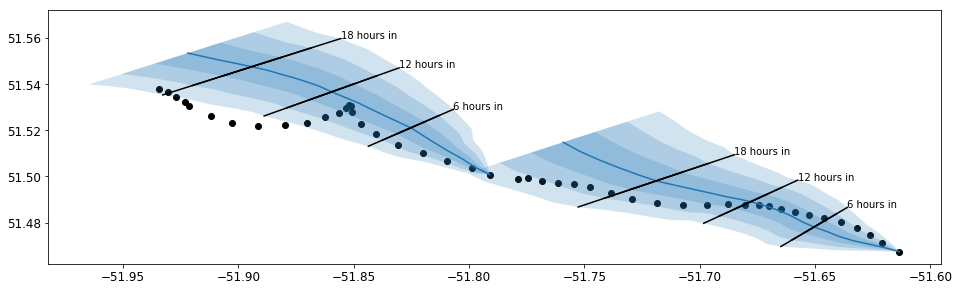

In [22]:
fig = plt.figure(figsize=(16, 10))

for key, sim in sims.items():
    
    ts = sim.results.data['reference'].time.values
    lats = sim.results.data['reference'].latitude.values
    lons = sim.results.data['reference'].longitude.values
    labels = [str(i) for i in range(N)]
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            data = sim.results.data[label]
            sim_lats[i, j] = float(data['latitude'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(data['longitude'].interp(time=t, assume_sorted=True).values)

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        mean_lats = np.mean(sim_lats, axis=1)
        mean_lons = np.mean(sim_lons, axis=1) 

        std1_lats = np.std(sim_lats, axis=1)
        std1_lons = np.std(sim_lons, axis=1)

        min1_lats = mean_lats - std1_lats
        min1_lons = mean_lons - std1_lons
        max1_lats = mean_lats + std1_lats
        max1_lons = mean_lons + std1_lons

        min2_lats = mean_lats - 2 * std1_lats
        min2_lons = mean_lons - 2 * std1_lons
        max2_lats = mean_lats + 2 * std1_lats
        max2_lons = mean_lons + 2 * std1_lons

        min3_lats = mean_lats - 3 * std1_lats
        min3_lons = mean_lons - 3 * std1_lons
        max3_lats = mean_lats + 3 * std1_lats
        max3_lons = mean_lons + 3 * std1_lons

        plt.plot(mean_lons, mean_lats, label='mean', color='C0')

        polygon1_xys = np.column_stack((np.vstack((min1_lons, max1_lons[::-1])).ravel(), 
                                        np.vstack((min1_lats, max1_lats[::-1])).ravel()))
        polygon2_xys = np.column_stack((np.vstack((min2_lons, max2_lons[::-1])).ravel(), 
                                        np.vstack((min2_lats, max2_lats[::-1])).ravel()))
        polygon3_xys = np.column_stack((np.vstack((min3_lons, max3_lons[::-1])).ravel(), 
                                        np.vstack((min3_lats, max3_lats[::-1])).ravel()))

        polygon1 = Polygon(polygon1_xys, fill=True, alpha=0.2, label='σ1')
        polygon2 = Polygon(polygon2_xys, fill=True, alpha=0.2, label='σ2')
        polygon3 = Polygon(polygon3_xys, fill=True, alpha=0.2, label='σ3')

        ax = plt.gca()
        ax.add_patch(polygon1)
        ax.add_patch(polygon2)
        ax.add_patch(polygon3)

        ax.scatter(lons, lats, color='k')


        # ADDING TIME LINES
        for dt in np.arange(6, 24, 6):
            for min_lons, max_lons, min_lats, max_lats in zip([min1_lons, min2_lons, min3_lons], 
                                                                     [max1_lons, max2_lons, max3_lons],
                                                                     [min1_lats, min2_lats, min3_lats], 
                                                                     [max1_lats, max2_lats, max3_lats]):

                xr_min_lats = xr.DataArray(data=min_lats, coords=[ts], dims=['time'])
                xr_min_lons = xr.DataArray(data=min_lons, coords=[ts], dims=['time'])
                xr_max_lats = xr.DataArray(data=max_lats, coords=[ts], dims=['time'])
                xr_max_lons = xr.DataArray(data=max_lons, coords=[ts], dims=['time'])
                t = ts[0] + np.timedelta64(int(dt), 'h')
                xr_min_lat = float(xr_min_lats.interp(time=t, assume_sorted=True).values)
                xr_min_lon = float(xr_min_lons.interp(time=t, assume_sorted=True).values)
                xr_max_lat = float(xr_max_lats.interp(time=t, assume_sorted=True).values)
                xr_max_lon = float(xr_max_lons.interp(time=t, assume_sorted=True).values)
                ax.plot([xr_min_lon, xr_max_lon], [xr_min_lat, xr_max_lat], color='k', zorder=10)
            ax.annotate(s=f'{dt} hours in', xy=[xr_max_lon, xr_max_lat])
        #

        # ax.set_ylim(51.4, 51.65)
ax.set_aspect('equal', adjustable='box')   

#plt.legend()

# Perturb Current and Wind Velocities

In [7]:
def subset_ds(ds, bounds_by_colname):
    for colname, bounds in bounds_by_colname.items():
        ds = ds.where((ds[colname] >= bounds[0]) & (ds[colname] <= bounds[1]), drop=True)
    return ds

def get_bivariate_distribution(ds, field, time_bounds, latitude_bounds, longitude_bounds, return_uv=False):
    
    bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}
    sub_ds = subset_ds(ds, bounds_by_colname)    
    df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
        
    for i in range(len(sub_ds.time.values)):
        
        t = sub_ds.time.values[i]
        x = sub_ds.longitude.values[i]
        y = sub_ds.latitude.values[i]
        
        if len(sub_ds.eastward_velocity.shape) == 2:
            u = sub_ds.eastward_velocity.values[i, 0]
            v = sub_ds.northward_velocity.values[i, 0]
            
        else:
            u = sub_ds.eastward_velocity.values[i]
            v = sub_ds.northward_velocity.values[i]
            
        if np.isfinite(u):
            if np.isfinite(v):
                iu, iv = field.interpolate((t, y, x))
                df.loc[len(df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

    U1 = df.u.values
    V1 = df.v.values
    U2 = df.iu.values
    V2 = df.iv.values
    
    fit = fit_bivariate_normal(U1 - U2, V1 - V2)
    
    if return_uv:
        return fit, [U1, V1, U2, V2]
    
    else:
        return fit

In [8]:
def plot_data_with_bivariate_distribution(distribution_c, distribution_w, UV_c, UV_w):
    
    U_c1, V_c1, U_c2, V_c2 = UV_c
    U_w1, V_w1, U_w2, V_w2 = UV_w
    
    fig = plt.figure(figsize=(10, 10))
    i = 0
    for params in [distribution_c, distribution_w]:
        ellipse1 = Ellipse(xy=params[0], width=2*params[1], height=2*params[2], angle=np.rad2deg(params[3]), 
                          alpha=0.8, edgecolor='b', lw=4, facecolor='none')
        ellipse2 = Ellipse(xy=params[0], width=2*2*params[1], height=2*2*params[2], angle=np.rad2deg(params[3]), 
                      alpha=0.8, edgecolor='b', lw=4, facecolor='none')
        if i == 0:
            ax = fig.add_subplot(121, aspect='equal')
            ax.set_title('Current Correction Distribution')
        else:
            ax = fig.add_subplot(122, aspect='equal')
            ax.set_title('Wind Correction Distribution')
        ax.axhline(y=0, color='grey')
        ax.axvline(x=0, color='grey')
        ax.scatter(*params[0], color='k', zorder=2)
        ax.annotate(s=f'{np.round(params[0], 2)}', xy=(params[0][0], params[0][1]), fontsize=14)
        if i == 0:
            ax.scatter(U_c1 - U_c2, V_c1 - V_c2, color='r')
        else:
            ax.scatter(U_w1 - U_w2, V_w1 - V_w2, color='r')
        ax.add_artist(ellipse1)
        ax.add_artist(ellipse2)
        ax.set_xlabel('dU')
        ax.set_ylabel('dV')
        i+=1

    fig.tight_layout()

In [9]:
adcp_ds = sd.get_adcp_ds()
avos_ds = sd.get_avos_ds()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


## +/- 10 days from start

In [30]:
start_time = tc.time_frame[0] - np.timedelta64(10, 'D')
end_time = tc.time_frame[1] + np.timedelta64(10, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

current_distribution, UV_c = get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds, model='ECMWF').current,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

wind_distribution, UV_w = get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)
current_distribution, wind_distribution

(([0.030926678548224052, -0.01264596568056077],
  0.14013853473630547,
  0.09848249771882077,
  0.19383806680246585),
 ([-4.830874416867884, -0.7319703795914418],
  6.792599938118684,
  5.317590178194657,
  -0.45788678689115525))

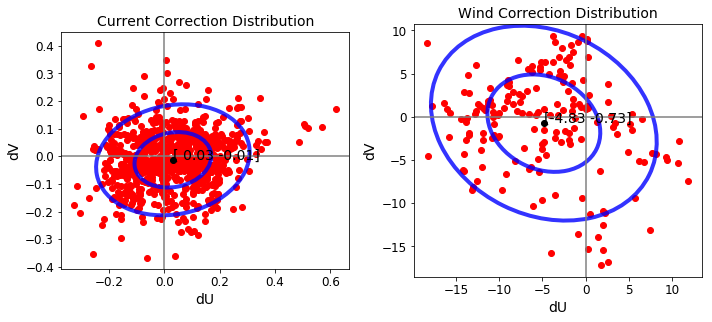

In [31]:
plot_data_with_bivariate_distribution(current_distribution, wind_distribution, UV_c, UV_w)

In [32]:
U_c1, V_c1, U_c2, V_c2 = UV_c 
dU_c = U_c1 - U_c2
dV_c = V_c1 - V_c2
df = pd.DataFrame(np.array([dU_c, dV_c]).T, columns=['dU', 'dV'])
df.to_csv('current_velocity_differences10.csv')

U_w1, V_w1, U_w2, V_w2 = UV_w 
dU_w = U_w1 - U_w2
dV_w = V_w1 - V_w2
df = pd.DataFrame(np.array([dU_w, dV_w]).T, columns=['dU', 'dV'])
df.to_csv('wind_velocity_differences10.csv')

## +/- 1 day from start

In [33]:
start_time = tc.time_frame[0] - np.timedelta64(1, 'D')
end_time = tc.time_frame[1] + np.timedelta64(1, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

current_distribution1, UV_c1 = get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds, model='ECMWF').current,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

wind_distribution1, UV_w1 = get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

current_distribution1, wind_distribution1

(([0.004259207031188701, -0.04021070540955816],
  0.1341277575544655,
  0.0985614055036261,
  0.11249854171764141),
 ([-9.888013671807787, 1.1123289370532514],
  4.197132312626123,
  2.834932361995365,
  0.43084340390637416))

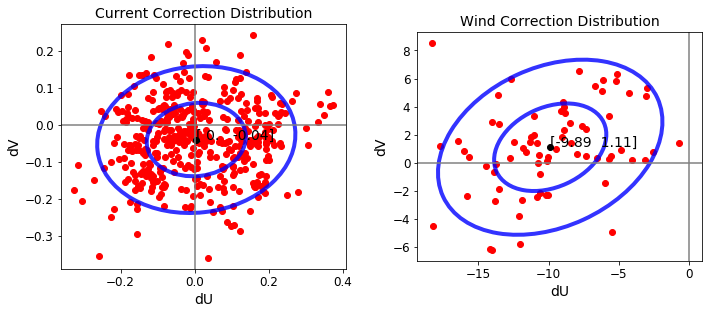

In [34]:
plot_data_with_bivariate_distribution(current_distribution1, wind_distribution1, UV_c1, UV_w1)

In [35]:
U_c1, V_c1, U_c2, V_c2 = UV_c1 
dU_c = U_c1 - U_c2
dV_c = V_c1 - V_c2
df = pd.DataFrame(np.array([dU_c, dV_c]).T, columns=['dU', 'dV'])
df.to_csv('current_velocity_differences1.csv')

U_w1, V_w1, U_w2, V_w2 = UV_w1
dU_w = U_w1 - U_w2
dV_w = V_w1 - V_w2
df = pd.DataFrame(np.array([dU_w, dV_w]).T, columns=['dU', 'dV'])
df.to_csv('wind_velocity_differences1.csv')

# Using Univariate Data (Magnitude and Direction)

In [47]:
speed_c1 = np.sqrt(U_c1**2 + V_c1**2)
speed_c2 = np.sqrt(U_c2**2 + V_c2**2)
speed_c = speed_c1 - speed_c2
direction_c1 = np.rad2deg(np.arctan2(U_c1, V_c1))
direction_c2 = np.rad2deg(np.arctan2(U_c2, V_c2))
angle_c = direction_c1 - direction_c2

for i, a in enumerate(angle_c): 
    if a > 180: 
        angle_c[i] -= 360
    elif a < -180:
        angle_c[i] += 360
        
speed_w1 = np.sqrt(U_w1**2 + V_w1**2)
speed_w2 = np.sqrt(U_w2**2 + V_w2**2)
speed_w = speed_w1 - speed_w2
direction_w1 = np.rad2deg(np.arctan2(U_w1, V_w1))
direction_w2 = np.rad2deg(np.arctan2(U_w2, V_w2))
angle_w = direction_w1 - direction_w2

for i, a in enumerate(angle_w): 
    if a > 180: 
        angle_w[i] -= 360
    elif a < -180:
        angle_w[i] += 360

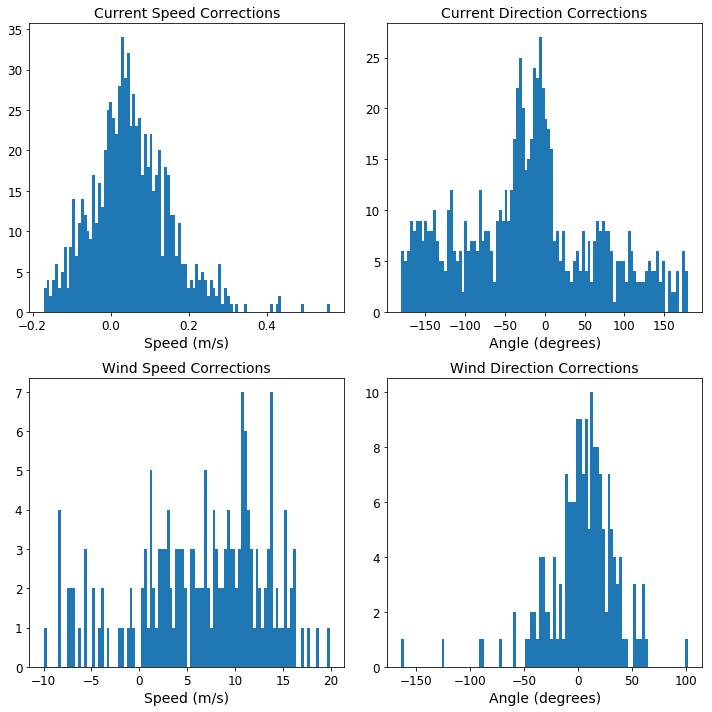

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].hist(speed_c, bins=100)
axes[0, 0].set_title('Current Speed Corrections')
axes[0, 0].set_xlabel('Speed (m/s)')

axes[0, 1].hist(angle_c, bins=100)
axes[0, 1].set_title('Current Direction Corrections')
axes[0, 1].set_xlabel('Angle (degrees)')

axes[1, 0].hist(speed_w, bins=100)
axes[1, 0].set_title('Wind Speed Corrections')
axes[1, 0].set_xlabel('Speed (m/s)')

axes[1, 1].hist(angle_w, bins=100)
axes[1, 1].set_title('Wind Direction Corrections')
axes[1, 1].set_xlabel('Angle (degrees)')

fig.tight_layout()

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

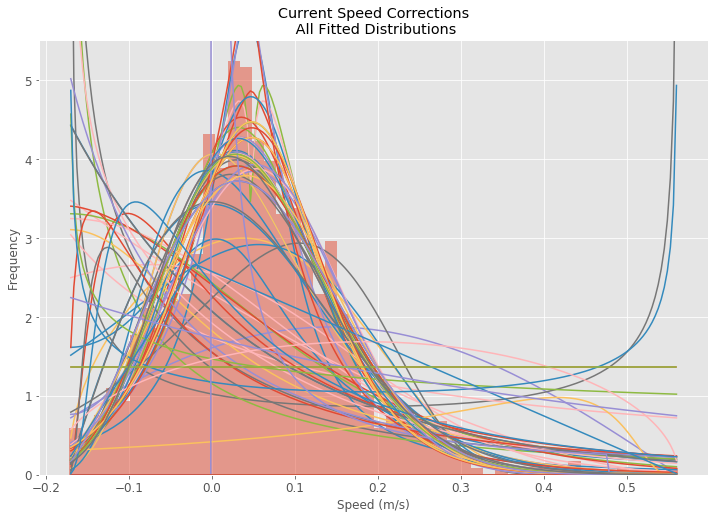

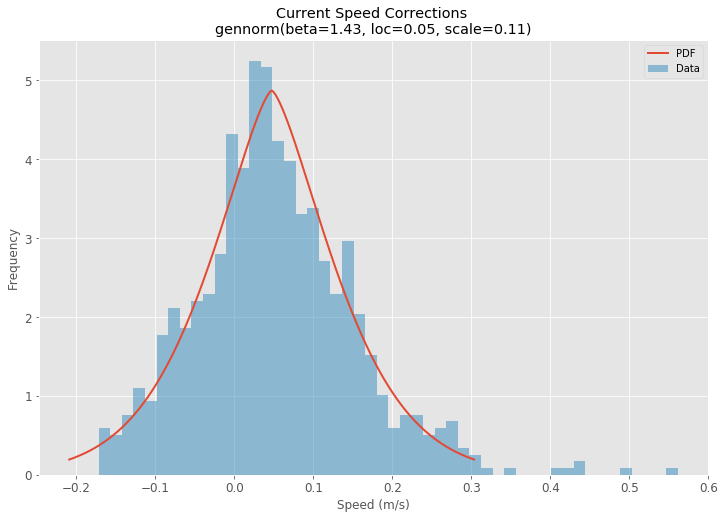

In [60]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = pd.Series(speed_c)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Current Speed Corrections\n All Fitted Distributions')
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Current Speed Corrections \n' + dist_str)
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

In [67]:
scipy.stats.gennorm.rvs(beta=1.43, loc=0.05, scale=0.11, size=10)

array([0.03385612, 0.0242569 , 0.01096704, 0.05410759, 0.13434438,
       0.41057846, 0.09303097, 0.06316217, 0.03136094, 0.07602124])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

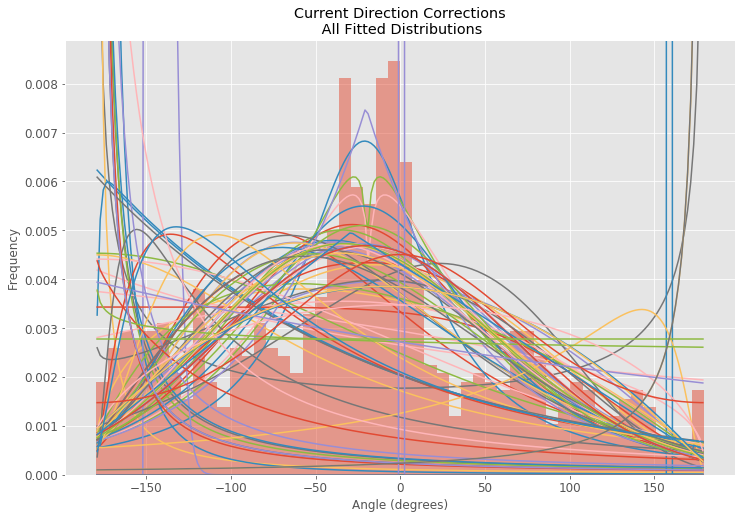

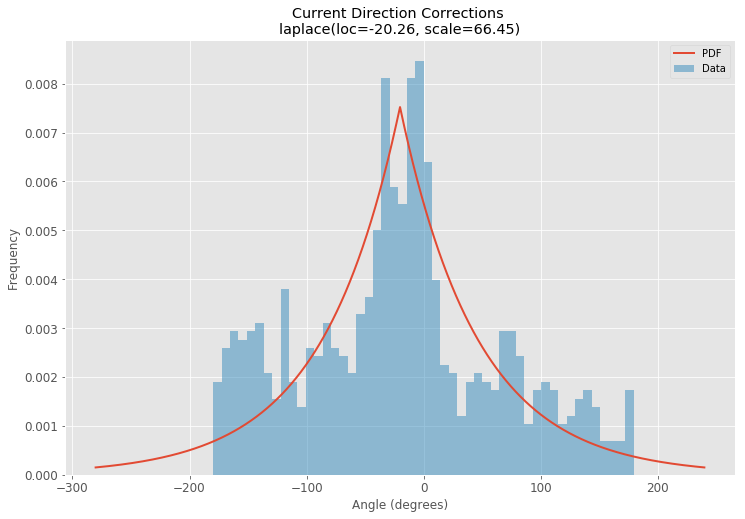

In [61]:
data = pd.Series(angle_c)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Current Direction Corrections\n All Fitted Distributions')
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Current Direction Corrections \n' + dist_str)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

In [72]:
scipy.stats.laplace.rvs(loc=-20.26, scale=66.45, size=10)

array([ -50.42353926,   -0.38737154, -282.38025876,  -70.19928744,
         12.36845627,   27.18534238,  -53.99376527,  152.30956001,
       -197.9636201 , -128.90297819])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

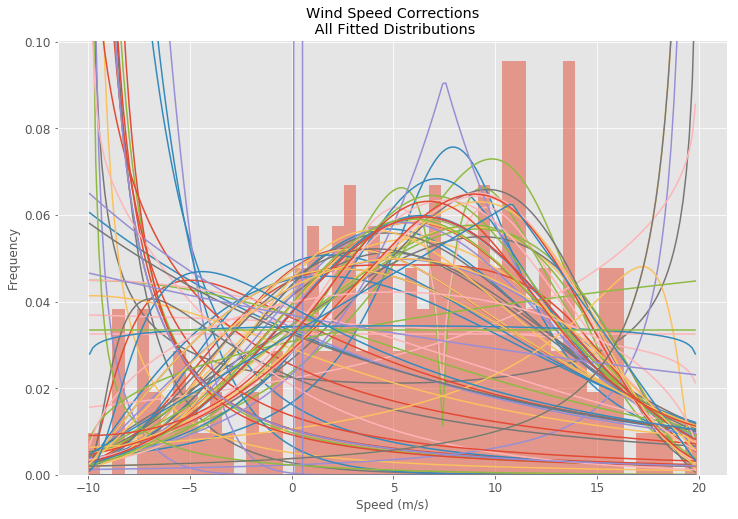

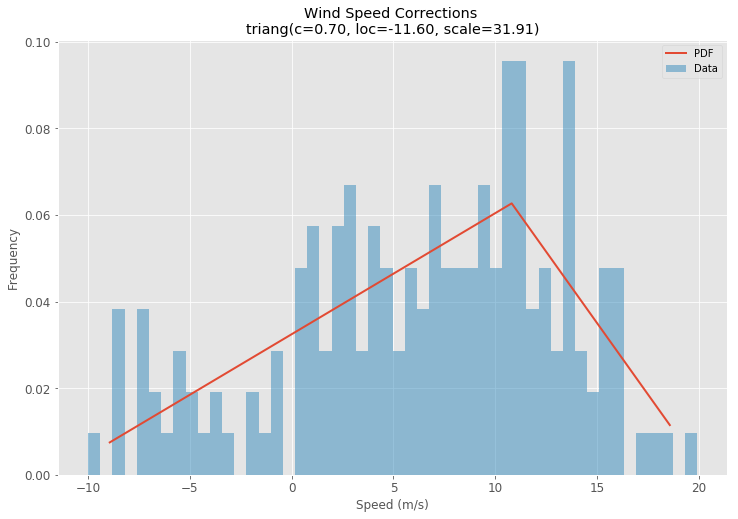

In [62]:
data = pd.Series(speed_w)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Wind Speed Corrections\n All Fitted Distributions')
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Wind Speed Corrections \n' + dist_str)
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

In [69]:
scipy.stats.triang.rvs(c=0.70, loc=-11.60, scale=31.91, size=10)

array([17.97352126, 10.96928698, 10.00325103,  6.30436467, -8.7888963 ,
        1.80778318, 14.56655909, 13.9772861 , 10.59556168, 10.68382599])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

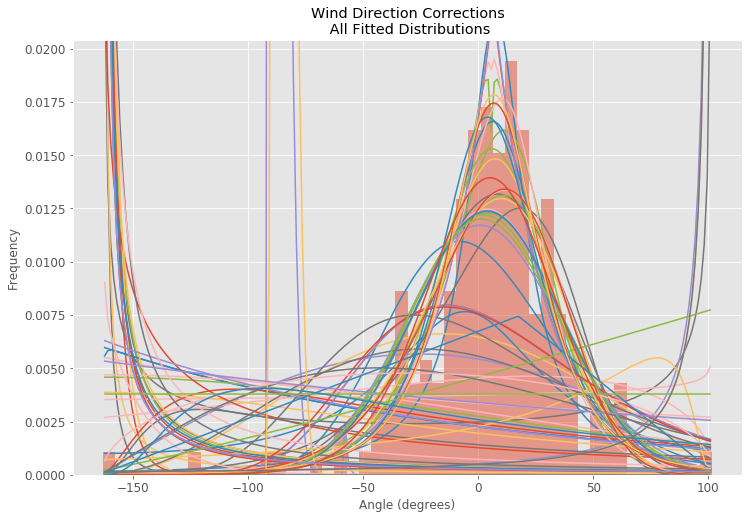

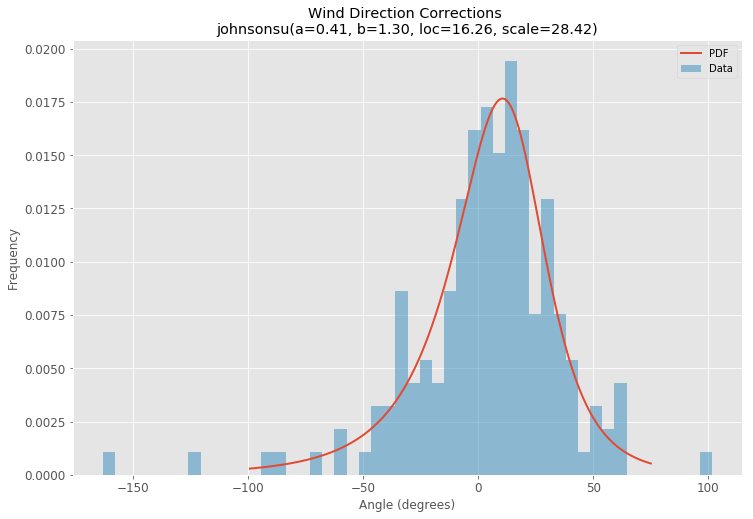

In [63]:
data = pd.Series(angle_w)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Wind Direction Corrections\n All Fitted Distributions')
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Wind Direction Corrections \n' + dist_str)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

In [71]:
scipy.stats.johnsonsu.rvs(a=0.41, b=1.30, loc=16.26, scale=28.42, size=10)

array([  40.96935884,   26.50381449,   31.33107052,    4.70890682,
       -112.330291  ,   -2.32828953,    3.02440866,   -4.19846313,
          5.08592955,  -18.87115839])

## Simulate Using Distributions for Corrections

In [81]:
sim.add_current_distribution(current_distribution)
sim.add_wind_distribution(wind_distribution)

In [85]:
Ca, Cw = 1, 0.75
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.5}
labels = ['reference']
for i in range(5):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    labels.append(f'{i}')

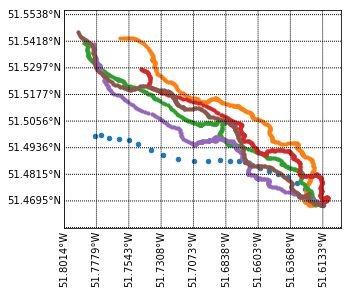

In [86]:
sizes = [20] + [10] * 10
#plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = sim.results.plot(labels, sizes=sizes)#, labels=labels)

In [17]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy', 
                                         'Vwx', 'Vwy', 'Vcx', 'Vcy', 'Amwx', 'Amwy'])

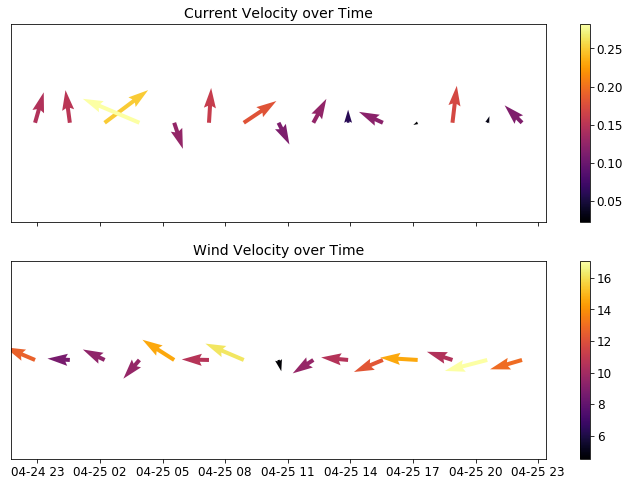

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
u = forces['Vcx'][::20].values
v = forces['Vcy'][::20].values

uv = np.sqrt(u**2 + v**2)
x = sim.results.data['0'].time.values[::20]
y = [0] * len(x)

norm = matplotlib.colors.Normalize()
norm.autoscale(uv)
cm = matplotlib.cm.inferno

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
ax1.quiver(x, y, u, v, color=cm(norm(uv)))
plt.colorbar(sm, ax=ax1)
ax1.set_title('Current Velocity over Time')
ax1.axes.get_yaxis().set_visible(False)

u = forces['Vwx'][::20].values
v = forces['Vwy'][::20].values
uv = np.sqrt(u**2 + v**2)
norm = matplotlib.colors.Normalize()
norm.autoscale(uv)
cm = matplotlib.cm.inferno

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
ax2.quiver(x, y, u, v, color=cm(norm(uv)))
plt.colorbar(sm, ax=ax2)
ax2.set_title('Wind Velocity over Time')
ax2.axes.get_yaxis().set_visible(False)

plt.show()

In [88]:
sim.add_current_distribution(current_distribution1)
sim.add_wind_distribution(wind_distribution1)

In [96]:
Ca, Cw = 1.5, 1.5
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.5}
labels = []
N = 10
for i in range(N):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    labels.append(f'{i}')
labels.append('reference')

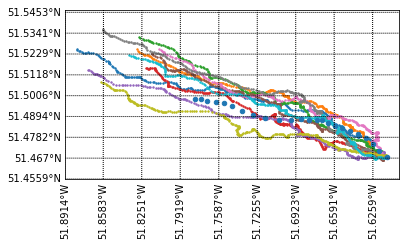

In [99]:
sizes = [2] * N + [20]
#plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = sim.results.plot(labels, sizes=sizes)#, labels=labels)

# Optimizing Ca and Cw

### Scipy minimize

In [290]:
run_optimization = False

if not run_optimization:
    optimization_result = type('dummy', (object,), {})()
    optimization_result.x = np.array([9.15857407, 1.94167373])
    
else:
    
    keys = ['Ca', 'Cw']
    x0 = [1, 1]
    bounds = [[0.01, 15], [0.01, 15]]
    reference_vectors = [tc.ref_lats, tc.ref_lons]
    optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

optimization_result.x

array([9.15857407, 1.94167373])

In [291]:
Ca, Cw = optimization_result.x
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
sim.run_simulation(label='optimized', **run_sim_kwargs)

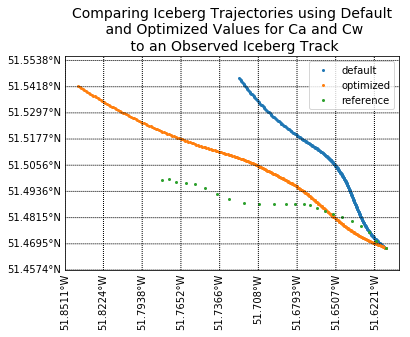

In [292]:
title = 'Comparing Iceberg Trajectories using Default\n and Optimized Values for Ca and Cw\n to an Observed Iceberg Track'
sizes = 4
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'sizes': sizes, 'legend_kwargs': legend_kwargs}
fig, ax = sim.results.plot(['default', 'optimized', 'reference'], labels=['default', 'optimized', 'reference'], 
                         **kwargs)
fig.savefig(plot_dir + 'tracks_from_default_and_optimized_Ca_and_Cw.png', bbox_inches='tight')

### Brute force

In [24]:
Ca_num = 16
Cw_num = 16
Ca_lower_bound = 0.1; Ca_upper_bound = 15
Cw_lower_bound = 0.1; Cw_upper_bound = 15

data_filename = data_dir + f'mses_for_Ca_{Ca_lower_bound}-{Ca_upper_bound}_and_Cw_{Cw_lower_bound}-{Cw_upper_bound}.npy'

try:
    mse_matrix = np.load(data_filename)

except FileNotFoundError:
    
    scaling = 'lin'

    if scaling == 'log':

        Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
        Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

    elif scaling == 'lin':

        Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
        Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


    Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

    mse_matrix = np.zeros((Ca_num, Cw_num))
    keys = ['Ca', 'Cw']
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    for i in range(Ca_num):
        for j in range(Cw_num):
            form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
            mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)
            
    np.save(data_filename, mse_matrix)

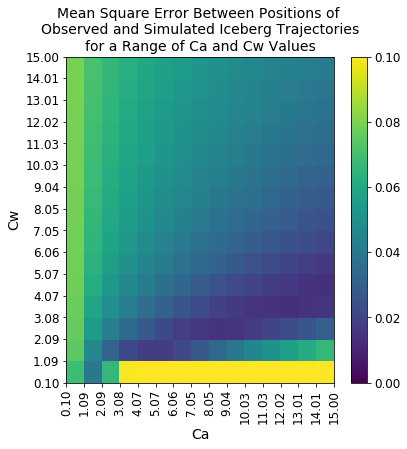

In [25]:
fig = plt.figure(figsize=(6,6))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0, vmax=0.1)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.title('Mean Square Error Between Positions of \n'+ \
          'Observed and Simulated Iceberg Trajectories\n' + \
          'for a Range of Ca and Cw Values')

plt.colorbar()

plt.show()

fig.savefig(plot_dir + 'mse_color_plot.png', bbox_inches='tight')

# Distance Between Observed and Optimized Tracks

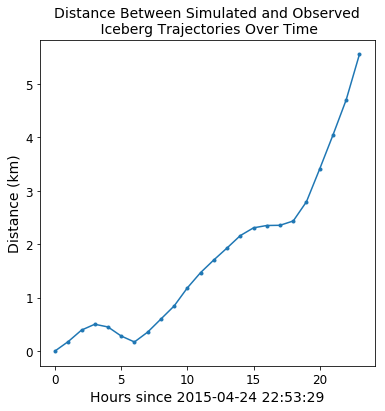

In [253]:
norms = sim.results.compute_distance_between_two_tracks('reference', 'optimized')
plt.plot(norms, '.-')
plt.ylabel('Distance (km)')
plt.xlabel('Hours since {}'.format(pd.Timestamp(tc.ref_times[0])))
plt.title('Distance Between Simulated and Observed\n Iceberg Trajectories Over Time')
plt.show()

# Varying size while using optimal drag coefficients

In [342]:
sim.time_stepper = timesteppers.rk4
sim.iceberg_size = 1000, 300 # VLG
sim.run_simulation(label='vlg_optimized', **{'Ca': Ca, 'Cw': Cw})
sim.iceberg_size = 60, 120 # MED
sim.run_simulation(label='med_optimized', **{'Ca': Ca, 'Cw': Cw})
sim.iceberg_size = 40, 80 # SM
sim.run_simulation(label='sm_optimized', **{'Ca': Ca, 'Cw': Cw})

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2591d7cba8>)

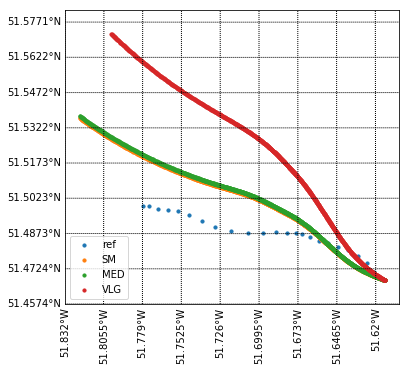

In [343]:
sim.results.plot(['reference', 'sm_optimized', 'med_optimized', 'vlg_optimized'], 
                 labels=['ref', 'SM', 'MED', 'VLG'], sizes=10)

In [337]:
keys = ['Ca', 'Cw', 'waterline_length', 'sail_height']
x0 = [1, 1, 120, 60]
#bounds = [[0.01, 15], [0.01, 15], [80, 160], [40, 80]]
bounds = [[1, 10], [1, 10], [80, 160], [40, 80]]
reference_vectors = [tc.ref_lats, tc.ref_lons]
sim.time_stepper = timesteppers.euler
sim.time_step = np.timedelta64(100, 's')
optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors, 
                                           optimizer='differential_evolution', **{'maxiter': 1})

In [338]:
optimization_result

     fun: 0.013584061209369419
     jac: array([1.49649390e-05, 2.05912544e-04, 1.38403178e-05, 0.00000000e+00])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 230
     nit: 1
 success: False
       x: array([  9.42608308,   2.46374446, 110.90713947,  56.83006815])

In [340]:
Ca, Cw, waterline_length, sail_height = optimization_result.x
kwargs = {'Ca': Ca, 'Cw': Cw, 'waterline_length': waterline_length, 'sail_height': sail_height}
sim.run_simulation(label='optimized_Ca_Cw_and_size', **kwargs)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f25b024af98>)

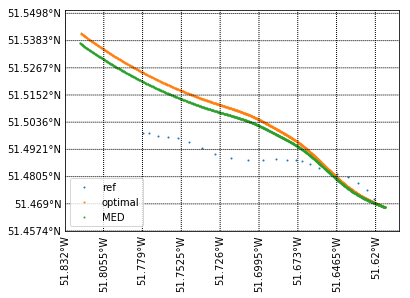

In [345]:
sim.results.plot(['reference', 'optimized_Ca_Cw_and_size', 'med_optimized'], labels=['ref', 'optimal', 'MED'])